# Make Training data

## Extract mother cell database for each barcode

In [1]:
# Import dependencies
import numpy as np
from cellpose_omni import models, core, plot
import os
import zarr
from tqdm import tqdm
from natsort import natsorted
from glob import glob
from cellpose_omni import models
from cellpose_omni.models import MODEL_NAMES
import time
from PIL import Image
from IPython.display import display
import omnipose
import pickle

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['figure.dpi'] = 300
# plt.style.use('dark_background')
%matplotlib inline

2025-05-26 10:45:06,513 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True


In [2]:
import os
# os.environ["JOBLIB_TEMP_FOLDER"] = "C:/temp"
# os.makedirs("C:/temp", exist_ok=True)
os.makedirs("D:/temp", exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/temp"

In [3]:
basedir = os.getcwd()
print(basedir)
barcode = "1111"

# Open the existing zarr file
#z1 = zarr.open(basedir + '\\trenches_best_bluebothexp100.zarr', mode='r')
z1 = zarr.open(os.path.join(basedir, f'trenches_{barcode}.zarr'), mode='r')
print(z1.shape)

# Create a new zarr file with the same shape
z2 = zarr.open(basedir + '\\masks_uninduced_all_2.zarr', mode='w', shape=z1.shape)
print(z2.shape)
z2.shape[1]/17

d:\PRISM
(600, 1, 3, 260, 60)
(600, 1, 3, 260, 60)


0.058823529411764705

(260, 60)


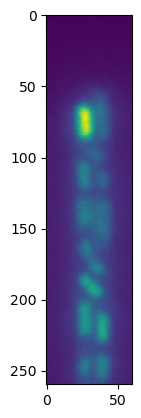

In [4]:
trench_num = 156
frame_num = 0
channel = 2
img_PIL = Image.fromarray(z1[trench_num, frame_num, channel])
# display(img_PIL)
test = [np.concatenate(z1[trench_num, frame_num:frame_num+40, channel], axis=1)]
print(test[-1].shape)
plt.imshow(test[-1])
plt.show()

In [22]:
import napari

# Assuming z1 is your Zarr dataset
viewer = napari.Viewer()

# Add the Zarr data to the viewer
viewer.add_image(z1, name='Trench Data')

# Start the napari viewer
napari.run()


In [5]:
model_path = r"D:\PRISM\Omnipose_train\SyMBacData\100x_pc_20250510\TD2\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD2_2025_05_10_22_14_11.213998_epoch_149"
# Initialize the model using the specific path
model = models.CellposeModel(gpu=use_GPU, pretrained_model=model_path, omni=True, concatenation=True)
# chans = [0,0]  #this means segment based on first channel, no second channel 
chans = [0,0]

# n = [-1] # make a list of integers to select which images you want to segment
# n = range(nimg) # or just segment them all 

# define parameters
params = {'channels':None, # always define this with the model
          'rescale': None, # upscale or downscale your images, None = no rescaling 
          'mask_threshold': -1, # erode or dilate masks with higher or lower values 
          'flow_threshold': 0., # default is .4, but only needed if there are spurious masks to clean up; slows down output
          'transparency': True, # transparency in flow output
          'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
          'cluster': True, # use DBSCAN clustering
          'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
          'verbose': 0, # turn on if you want to see more output 
          'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
          'niter': None, # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
          'augment': False, # Can optionally rotate the image and average outputs, usually not needed 
          'affinity_seg': False, # new feature, stay tuned...
         }

2025-05-23 17:56:55,980 [INFO] ** TORCH GPU version installed and working. **
2025-05-23 17:56:55,981 [INFO] >>>> using GPU


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(filen

In [ ]:
# segment each cell and adjust masks across channels
import zarr
import numpy as np
import time
from tqdm import tqdm
from copy import deepcopy
import math
import os

# Define the function to align FL images based on the mask
def align_FL_mask(FL_image, mask):
    mask = mask > 0
    optimal_image = deepcopy(FL_image)
    current_sum = (optimal_image * mask).sum()
    
    for x in range(-6, 7):
        rolled_x = np.roll(FL_image, x, axis=1)
        for y in range(-6, 7):
            rolled_y = np.roll(rolled_x, y, axis=0)
            FL_sum = np.sum(rolled_y * mask)
            if FL_sum > current_sum:
                optimal_image = rolled_y
                current_sum = FL_sum
    
    return optimal_image

# Define the segmentation and alignment function
def segment_and_align(z1, z2, z1_adjusted, model, params, w=50):
    N = math.ceil(z2.shape[1] / w)
    print("Total segments:", N)
    tic = time.time()
    
    # Process each trench
    for i in tqdm(range(z1.shape[0])):
        for j in range(N):
            # Segment the first channel (PC)
            pc_image = z1[i, j*w:(j+1)*w, 0, :, :]
            concat = np.concatenate(pc_image, axis=1)
            
            try:
                # Perform segmentation on the concatenated PC images
                masks, flows, styles = model.eval(concat, **params)
                individual_masks = np.array_split(masks, pc_image.shape[0], axis=1)
                
                # Use only the mother cell mask (topmost cell) for alignment
                mother_cell_mask = individual_masks[0]  # Assuming the first mask corresponds to the mother cell

                # Copy the original PC images directly to z1_adjusted
                z1_adjusted[i, j*w:(j+1)*w, 0, :, :] = pc_image

                # Apply the mask to all channels in z2
                if (j+1)*w <= z2.shape[1]:
                    for ch in range(z2.shape[2]):
                        z2[i, j*w:(j+1)*w, ch] = np.array(individual_masks)  # Overlay mask on each channel
                        
                        # Align each FL channel based on the mother cell mask
                        if ch > 0:  # Skip alignment for the first channel (PC)
                            for img_idx, mask in enumerate(individual_masks):
                                FL_image = z1[i, j*w + img_idx, ch, :, :]
                                aligned_FL_image = align_FL_mask(FL_image, mask)
                                z1_adjusted[i, j*w + img_idx, ch, :, :] = aligned_FL_image
                else:
                    for ch in range(z2.shape[2]):
                        z2[i, j*w:, ch] = np.array(individual_masks)  # Overlay mask on each channel for remaining segments
                        
                        # Align each FL channel based on the mother cell mask
                        if ch > 0:  # Skip alignment for the first channel (PC)
                            for img_idx, mask in enumerate(individual_masks):
                                FL_image = z1[i, j*w + img_idx, ch, :, :]
                                aligned_FL_image = align_FL_mask(FL_image, mask)
                                z1_adjusted[i, j*w + img_idx, ch, :, :] = aligned_FL_image

            except ValueError as e:
                print(f"Error processing trench {i}, segment {j}: {e}")
                pass

    net_time = time.time() - tic
    print('Total segmentation and alignment time: {}s'.format(net_time))

# Set base directory and create new writable Zarr arrays for adjusted images and masks
basedir = os.getcwd()
z1_adjusted = zarr.open(basedir + '/z1_adjusted.zarr', mode='w', shape=z1.shape, dtype=z1.dtype)
z2 = zarr.open(basedir + '/masks_uninduced_all_2.zarr', mode='w', shape=z1.shape, dtype=z1.dtype)

# Call the segmentation and alignment function
segment_and_align(z1, z2, z1_adjusted, model, params, w=50)


Total segments: 1


  0%|          | 1/600 [00:01<15:50,  1.59s/it]c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

2025-05-23 18:01:49,860 [INFO] No cell pixels found.


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\cellpose_omni\resnet_torch.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(filen

Total segmentation and alignment time: 383.58770275115967s


In [30]:
import napari

def view_with_napari(image_zarr, mask_zarr):
    with napari.gui_qt():
        viewer = napari.Viewer()

        # Add original images
        viewer.add_image(image_zarr, name='Original Images', colormap='gray', contrast_limits=[0, 255])

        # Convert masks to integer type and add them as labels
        mask_int = mask_zarr.astype(np.int32)  # Convert float masks to integers
        viewer.add_labels(mask_int, name='Masks', opacity=0.5)

# Call the function to launch Napari
view_with_napari(z1_adjusted, z2)


c:\Users\kastu\miniconda3\envs\PRISM\lib\contextlib.py:135: FutureWarning: 
The 'gui_qt()' context manager is deprecated.
If you are running napari from a script, please use 'napari.run()' as follows:

    import napari

    viewer = napari.Viewer()  # no prior setup needed
    # other code using the viewer...
    napari.run()

In IPython or Jupyter, 'napari.run()' is not necessary. napari will automatically
start an interactive event loop for you: 

    import napari
    viewer = napari.Viewer()  # that's it!

  return next(self.gen)
c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\napari\_qt\qt_event_loop.py:306: FutureWarning: `QApplication` instance access through `get_app` is deprecated and will be removed in 0.6.0.
Please use `get_qapp` instead.

  app = get_app()


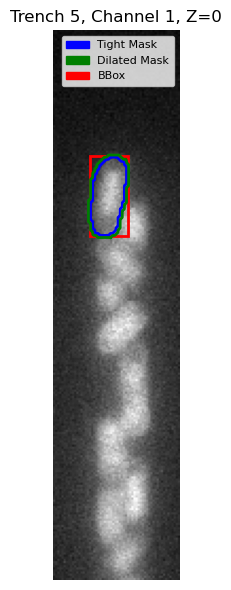

In [9]:
# Show each step of cropping
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import dilation, square
from skimage.measure import find_contours
import matplotlib.patches as patches

# ── Load data ─────────────────────────────────────────────────────────
basedir = os.getcwd()
z1 = zarr.open(os.path.join(basedir, 'z1_adjusted.zarr'), mode='r')  # [trenches, z, ch, H, W]
z2 = zarr.open(os.path.join(basedir, 'masks_uninduced_all_2.zarr'), mode='r')  # [trenches, z, 1, H, W]

def visualize_mask_expansion(trench_id, channel=1, z_plane=0, dilation_radius=1):
    """
    Display the original fluorescence image for a trench with overlays showing:
    - Tight mother-cell mask contour
    - Dilated mask contour
    - Bounding box of the dilated mask
    """
    # Extract arrays
    img = z1[trench_id, z_plane, channel].astype(np.float32)
    img = (img - img.min()) / (img.ptp() + 1e-8)  # normalize
    mask = z2[trench_id, z_plane, 0]

    # Identify mother-cell label
    coords = np.argwhere(mask > 0)
    top_row = coords[:, 0].min()
    xs_top = coords[coords[:, 0] == top_row][:, 1]
    mother_label = mask[top_row, xs_top[0]]
    mother_mask = (mask == mother_label).astype(np.uint8)

    # Tight mask contour
    tight_contours = find_contours(mother_mask, level=0.5)

    # Dilate mask and contour
    dilated_mask = dilation(mother_mask, square(2 * dilation_radius + 1))
    dil_contours = find_contours(dilated_mask, level=0.5)

    # Compute bounding box for dilated mask
    ys, xs = np.nonzero(dilated_mask)
    min_y, max_y = ys.min(), ys.max()
    min_x, max_x = xs.min(), xs.max()

    # Plot original image with overlays
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Plot tight mask contours in blue
    for contour in tight_contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue', label='Tight Mask')

    # Plot dilated mask contours in green
    for contour in dil_contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='green', label='Dilated Mask')

    # Plot bounding box in red
    rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                             linewidth=2, edgecolor='red', facecolor='none', label='BBox')
    plt.gca().add_patch(rect)

    # Legend
    handles = [
        patches.Patch(color='blue', label='Tight Mask'),
        patches.Patch(color='green', label='Dilated Mask'),
        patches.Patch(color='red', label='BBox')
    ]
    plt.legend(handles=handles, loc='upper right', fontsize=8)

    plt.title(f"Trench {trench_id}, Channel {channel}, Z={z_plane}", fontsize=12)
    plt.tight_layout()
    plt.show()

# Example: visualize trench 5, red channel, first Z-plane
visualize_mask_expansion(trench_id=5, channel=1, z_plane=0)




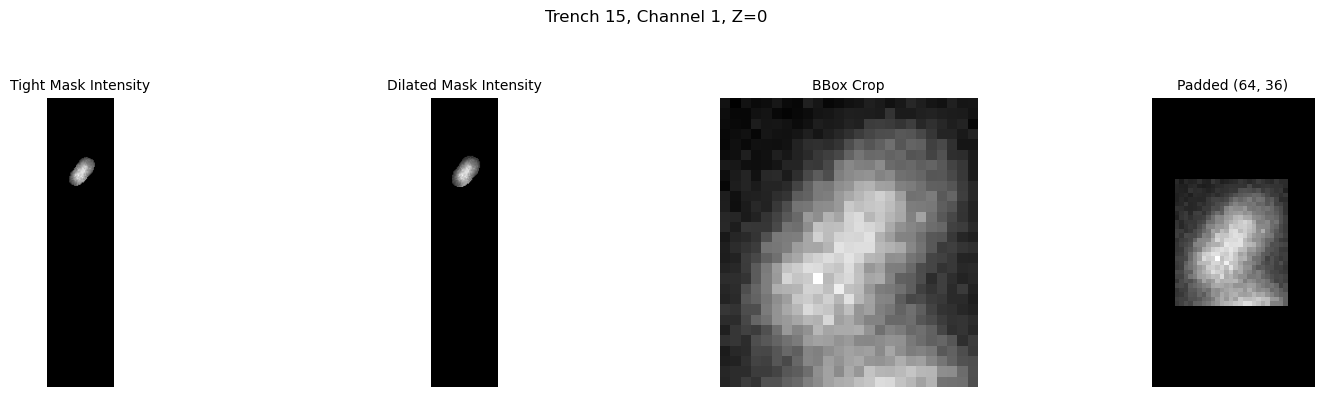

In [14]:
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import dilation, square

# ── Load data ─────────────────────────────────────────────────────────
basedir = os.getcwd()
z1 = zarr.open(os.path.join(basedir, 'z1_adjusted.zarr'), mode='r')  # [trenches, z, ch, H, W]
z2 = zarr.open(os.path.join(basedir, 'masks_uninduced_all_2.zarr'), mode='r')  # [trenches, z, 1, H, W]

def visualize_mother_cell_steps(trench_id, channel=1, z_plane=0, dilation_radius=1, target_shape=(64,36)):
    """
    Plot four steps for the mother cell in a trench:
      1) Tight-mask intensity
      2) Dilated-mask intensity
      3) Bounding-box crop
      4) Padded image
    """
    # Extract image and mask
    img = z1[trench_id, z_plane, channel].astype(np.float32)
    img = (img - img.min()) / (img.ptp() + 1e-8)
    mask = z2[trench_id, z_plane, 0]

    # Identify mother-cell label
    coords = np.argwhere(mask > 0)
    top_row = coords[:, 0].min()
    xs_top = coords[coords[:, 0] == top_row][:, 1]
    mother_label = mask[top_row, xs_top[0]]
    mother_mask = (mask == mother_label).astype(np.uint8)

    # 1) Tight-mask intensity
    tight_intensity = img * mother_mask

    # 2) Dilated mask and intensity
    dil_mask = dilation(mother_mask, square(2*dilation_radius+1))
    dilated_intensity = img * dil_mask

    # 3) Bounding-box crop
    ys, xs = np.nonzero(dil_mask)
    min_y, max_y = ys.min(), ys.max()
    min_x, max_x = xs.min(), xs.max()
    bbox_crop = img[min_y:max_y+1, min_x:max_x+1]

    # 4) Padded image
    h, w = bbox_crop.shape
    padded = np.zeros(target_shape, dtype=bbox_crop.dtype)
    if h <= target_shape[0] and w <= target_shape[1]:
        start_y = (target_shape[0] - h) // 2
        start_x = (target_shape[1] - w) // 2
        padded[start_y:start_y+h, start_x:start_x+w] = bbox_crop

    # ── Plot horizontally ───────────────────────────────────────────────
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    titles = ["Tight Mask Intensity", "Dilated Mask Intensity", "BBox Crop", f"Padded {target_shape}"]
    images = [tight_intensity, dilated_intensity, bbox_crop, padded]

    for ax, im, title in zip(axes, images, titles):
        ax.imshow(im, cmap='gray')
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    plt.suptitle(f"Trench {trench_id}, Channel {channel}, Z={z_plane}", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# Example usage:
visualize_mother_cell_steps(trench_id=15, channel=1)


In [ ]:
# just a helper function for plots

def plot_cells_by_channel(filtered_images, start_trench=0, end_trench=5):
    """
    Plots filtered images for each trench in rows and channels in columns.
    
    Parameters:
    - filtered_images: The structured list where each entry corresponds to a trench,
                       and each trench contains a list of channel images.
    - start_trench: The starting index for the trench to visualize.
    - end_trench: The ending index (exclusive) for the trench to visualize.
    """
    num_trenches = end_trench - start_trench
    num_channels = len(filtered_images[0])  # Assuming each trench has the same number of channels
    
    # Define a smaller and more compact figure size
    plt.figure(figsize=(num_channels * 1.5, num_trenches * 1.5))
    
    for row_idx, trench_idx in enumerate(range(start_trench, end_trench)):
        trench_images = filtered_images[trench_idx]
        
        for col_idx, channel_image in enumerate(trench_images):
            ax = plt.subplot(num_trenches, num_channels, row_idx * num_channels + col_idx + 1)
            ax.imshow(channel_image, cmap='gray')
            ax.axis('off')
            
            # Adding column titles for each channel and row labels for each trench
            if row_idx == 0:
                ax.set_title(f"Ch {col_idx + 1}", fontsize=8, pad=3)
            if col_idx == 0:
                ax.set_ylabel(f"Trench {trench_idx}", rotation=90, fontsize=8, labelpad=5)
    
    # Adding a main title and adjusting layout for minimal space
    plt.suptitle(f"Filtered Images from Trenches {start_trench} to {end_trench - 1}", fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Minimize margins
    plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Minimal spacing between subplots
    plt.show()


# This code finds the mask of the mother cell, finds the bounding box and expands it slightly by a margin
from skimage.transform import resize

# Load the Zarr arrays
# Set the base directory
basedir = os.getcwd()

# Open the adjusted images (z1_adjusted) and masks (z2) in read mode
z1_adjusted = zarr.open(os.path.join(basedir, 'z1_adjusted.zarr'), mode='r')  # Adjusted images
z2 = zarr.open(os.path.join(basedir, 'masks_uninduced_all_2.zarr'), mode='r')  # Masks

# since flourescent images tend to be bigger and slightly shifted, add a margin to the bounding box for mother cell mask.
margin = 2

def extract_mother_cell_bbox(mask, margin=2):
    """
    Given a mask, return the bounding box coordinates of the top-most cell (mother cell)
    with an additional margin around it.
    """
    non_zero_coords = np.argwhere(mask > 0)
    if len(non_zero_coords) == 0:
        return None

    # Find top-most cell based on the minimum y-coordinate
    top_cell_coords = non_zero_coords[non_zero_coords[:, 0].argmin()]
    top_cell_label = mask[top_cell_coords[0], top_cell_coords[1]]

    # Get the bounding box for the mother cell
    cell_coords = np.argwhere(mask == top_cell_label)
    min_y, min_x = cell_coords.min(axis=0)
    max_y, max_x = cell_coords.max(axis=0)

    # Expand the bounding box by the specified margin
    min_y = max(min_y - margin, 0)
    max_y = min(max_y + margin, mask.shape[0] - 1)
    min_x = max(min_x - margin, 0)
    max_x = min(max_x + margin, mask.shape[1] - 1)

    return min_y, max_y, min_x, max_x

def crop_and_pad_image(image, bbox, target_shape=(64, 36)):
    """
    Crop the image around the bounding box and pad to the target shape if it fits within the target shape.
    Skip if the cropped image is larger than the target shape.
    """
    min_y, max_y, min_x, max_x = bbox
    cropped_image = image[min_y:max_y+1, min_x:max_x+1]

    # Check if the cropped image fits within the target shape
    crop_height, crop_width = cropped_image.shape
    if crop_height > target_shape[0] or crop_width > target_shape[1]:
        print(f"Skipping image: Cropped size ({crop_height}, {crop_width}) exceeds target shape {target_shape}.")
        return None  # Skip this image

    # Initialize a padded image of the target shape with zeros (background)
    padded_image = np.zeros(target_shape, dtype=cropped_image.dtype)

    # Calculate where to place the cropped image within the padded image
    start_y = (target_shape[0] - crop_height) // 2
    start_x = (target_shape[1] - crop_width) // 2

    # Insert the cropped image into the center of the padded image
    padded_image[start_y:start_y+crop_height, start_x:start_x+crop_width] = cropped_image

    return padded_image


def apply_bounding_box_and_resize(z1, z2, target_shape=(64, 36), margin=2):
    """
    Use bounding box approach to crop around the mother cell in each channel, add margin, and pad to target shape.
    Skip images where the cropped size exceeds the target shape.
    """
    processed_images = []  # Store the cropped, padded images for each trench and channel

    for i in range(z1.shape[0]):
        trench_images = []  # Store images for each channel in the current trench

        mask = z2[i, 0, 0, :, :]  # Assume the mask is in the first channel of z2
        bbox = extract_mother_cell_bbox(mask, margin=margin)

        if bbox is None:
            print(f"No cells found in trench {i}. Skipping...")
            processed_images.append([None] * z1.shape[2])  # Add None for each channel
            continue

        for channel in range(z1.shape[2]):
            img_channel = z1[i, 0, channel, :, :]  # Select the current channel
            padded_image = crop_and_pad_image(img_channel, bbox, target_shape=target_shape)  # Crop and pad
            if padded_image is None:  # If the image was skipped
                print(f"Skipping trench {i}, channel {channel} due to oversized crop.")
                trench_images.append(None)
                continue
            trench_images.append(padded_image)  # Append each channel image to the trench list

        processed_images.append(trench_images)  # Append trench images for all channels

    return processed_images


# -----------------------------------------------
# after you run apply_bounding_box_and_resize(...)
processed_images_6436 = apply_bounding_box_and_resize(
                            z1_adjusted, z2,
                            target_shape=(64, 36),
                            margin=margin)

# store it so the QC script can load it
proc_pkl = os.path.join(basedir,
                        f"processed_images_{barcode}.pkl")
import pickle
with open(proc_pkl, "wb") as fh:
    pickle.dump(processed_images_6436, fh)

print("Saved >", proc_pkl)
# -----------------------------------------------

# Display trenches 26 to 31 for verification
plot_cells_by_channel(processed_images_6436, start_trench=1, end_trench=6)



No cells found in trench 439. Skipping...
Skipping image: Cropped size (75, 30) exceeds target shape (64, 36).
Skipping trench 473, channel 0 due to oversized crop.
Skipping image: Cropped size (75, 30) exceeds target shape (64, 36).
Skipping trench 473, channel 1 due to oversized crop.
Skipping image: Cropped size (75, 30) exceeds target shape (64, 36).
Skipping trench 473, channel 2 due to oversized crop.
Skipping image: Cropped size (68, 21) exceeds target shape (64, 36).
Skipping trench 514, channel 0 due to oversized crop.
Skipping image: Cropped size (68, 21) exceeds target shape (64, 36).
Skipping trench 514, channel 1 due to oversized crop.
Skipping image: Cropped size (68, 21) exceeds target shape (64, 36).
Skipping trench 514, channel 2 due to oversized crop.


C:\Users\kastu\AppData\Local\Temp\ipykernel_67320\3391731343.py:35: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Minimize margins


## Quality Check for Segmentation error

In [19]:
# quality check for the segmented mother cells
# click on poor segmentation to reject them
import os
import pickle
import numpy as np
import pandas as pd
import zarr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import Button
from IPython import get_ipython

# Setup %matplotlib qt for full interactivity (use inline only for static)
ipython = get_ipython()
if ipython:
    ipython.run_line_magic('matplotlib', 'qt')

# ─────── USER VARIABLES ───────
#barcode = "0010"
basedir       = os.getcwd()
proc_pkl      = os.path.join(basedir, f'processed_images_{barcode}.pkl')
output_csv    = os.path.join(basedir, f'qc_{barcode}_mother_cells.csv')
out_clean_dir = os.path.join(basedir, f'{barcode}_accepted_mother')
grid_rows     = 8
grid_cols     = 10
# ──────────────────────────────

# Load preprocessed data
with open(proc_pkl, 'rb') as fh:
    processed = pickle.load(fh)  # list of [pc, bfp, rfp]


N = len(processed)
status = np.full(N, 'keep', dtype=object)  # default to 'keep'

# Internal tracking
page_size = grid_rows * grid_cols
cur_page = {'start': 0}
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
fig.suptitle(f"Click any image to reject (red). Default = keep", fontsize=30)
plt.subplots_adjust(bottom=0.15)

# Draw checkboxes on top of each cell
rects = {}
def draw_page(start_idx):
    for i in range(page_size):
        idx = start_idx + i
        r, c = divmod(i, grid_cols)
        ax = axes[r, c]
        ax.clear()
        ax.axis('off')

        if idx >= N or processed[idx][0] is None:
            ax.set_facecolor('gray')
            ax.set_title(f"T{idx} [SKIP]", fontsize=6, color='gray')
            continue

        pc = processed[idx][0]
        ax.imshow(pc, cmap='gray')

        if status[idx] == 'reject':
            rect = patches.Rectangle((0, 0), pc.shape[1], pc.shape[0],
                                     linewidth=3, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            rects[idx] = rect
        else:
            rects.pop(idx, None)

        # ax.set_title(f"T{idx}", fontsize=10)

    fig.canvas.draw_idle()


def on_click(event):
    for i in range(page_size):
        idx = cur_page['start'] + i
        if idx >= N:
            continue
        r, c = divmod(i, grid_cols)
        ax = axes[r, c]
        if ax == event.inaxes:
            status[idx] = 'reject' if status[idx] == 'keep' else 'keep'
            draw_page(cur_page['start'])
            break

def on_next(event):
    if cur_page['start'] + page_size < N:
        cur_page['start'] += page_size
        draw_page(cur_page['start'])

def on_prev(event):
    if cur_page['start'] - page_size >= 0:
        cur_page['start'] -= page_size
        draw_page(cur_page['start'])

def on_save(event):
    df = pd.DataFrame({'trench_idx': np.arange(N), 'qc': status})
    df.to_csv(output_csv, index=False)
    print(f"✅ QC saved to {output_csv}")

# Navigation buttons
axprev = plt.axes([0.3, 0.03, 0.1, 0.05])
axnext = plt.axes([0.41, 0.03, 0.1, 0.05])
axsave = plt.axes([0.75, 0.03, 0.15, 0.05])
bprev = Button(axprev, '⬅️ Prev')
bnext = Button(axnext, 'Next ➡️')
bsave = Button(axsave, 'Save')

bprev.on_clicked(on_prev)
bnext.on_clicked(on_next)
bsave.on_clicked(on_save)
fig.canvas.mpl_connect('button_press_event', on_click)

# First page
draw_page(0)
plt.show()


In [ ]:
# save accepted cells
with open(proc_pkl, 'rb') as fh:
    processed = pickle.load(fh)

df = pd.read_csv(output_csv)
accepted = df.query("qc == 'keep'").trench_idx.values
os.makedirs(out_clean_dir, exist_ok=True)

n_copied = 0

for i in accepted:
    pc, bfp, rfp = processed[i]
    
    # ✅ Skip if any image is None
    if pc is None or bfp is None or rfp is None:
        print(f"⚠️ Skipping trench {i}: one or more channels is None")
        continue

    dest = os.path.join(out_clean_dir, f"T{i:04}.zarr")
    g = zarr.open(dest, mode='w')
    g.create_dataset('pc',  data=pc,  chunks=True)
    g.create_dataset('bfp', data=bfp, chunks=True)
    g.create_dataset('rfp', data=rfp, chunks=True)
    n_copied += 1

print(f"✅ Copied {n_copied} accepted trenches to {out_clean_dir}")


In [89]:
import matplotlib.pyplot as plt
import zarr

def visualize_accepted_cells(zarr_dir, max_to_show=12):
    """
    Visualize up to `max_to_show` accepted cells from a given Zarr directory.
    """
    zarr_files = sorted([f for f in os.listdir(zarr_dir) if f.endswith('.zarr')])
    if not zarr_files:
        print(f"⚠️ No .zarr files found in {zarr_dir}")
        return
    
    n_show = min(len(zarr_files), max_to_show)
    print(f"🔍 Showing {n_show} of {len(zarr_files)} accepted cells")

    fig, axes = plt.subplots(n_show, 3, figsize=(10, n_show * 2.5))
    if n_show == 1:
        axes = np.expand_dims(axes, 0)

    for i, fname in enumerate(zarr_files[:n_show]):
        g = zarr.open(os.path.join(zarr_dir, fname), mode='r')
        pc, bfp, rfp = g['pc'][...], g['bfp'][...], g['rfp'][...]

        titles = ['PC', 'BFP', 'RFP']
        for j, img in enumerate([pc, bfp, rfp]):
            ax = axes[i, j]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"{titles[j]} - {fname}", fontsize=2)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 🔍 Call it with your output directory
visualize_accepted_cells(out_clean_dir, max_to_show=5)


🔍 Showing 5 of 586 accepted cells


In [4]:
import os
import re

# 1) Recursively find all "<barcode>_accepted_mother" folders under cwd
accepted_dirs = []
for root, dirs, _ in os.walk(os.getcwd()):
    for d in dirs:
        if d.endswith("_accepted_mother") and re.fullmatch(r"[01]{4}_accepted_mother", d):
            accepted_dirs.append(os.path.join(root, d))

# 2) Pattern for Zarr files: Txxxx.zarr
pattern = re.compile(r"^T(\d{4})\.zarr$")

# 3) Compute number of trenches (max index + 1) for each barcode
trenches_per_barcode = {}
for folder in sorted(accepted_dirs):
    barcode = os.path.basename(folder).split("_")[0]
    max_idx = -1
    for fname in os.listdir(folder):
        m = pattern.match(fname)
        if m:
            idx = int(m.group(1))
            if idx > max_idx:
                max_idx = idx
    trenches_per_barcode[barcode] = (max_idx + 1) if max_idx >= 0 else 0

# 4) Sum total trenches across all barcodes
total_trenches = sum(trenches_per_barcode.values())

# 5) Print results
print("Number of trenches (mother cells) per barcode:")
for bc, count in sorted(trenches_per_barcode.items()):
    print(f"  {bc}: {count}")
print(f"\nTotal trenches across all barcodes: {total_trenches}")


Number of trenches (mother cells) per barcode:
  0001: 443
  0010: 446
  0011: 503
  0100: 445
  0101: 504
  0110: 563
  0111: 414
  1000: 519
  1001: 588
  1010: 590
  1011: 600
  1100: 950
  1101: 572
  1110: 420
  1111: 600

Total trenches across all barcodes: 8157


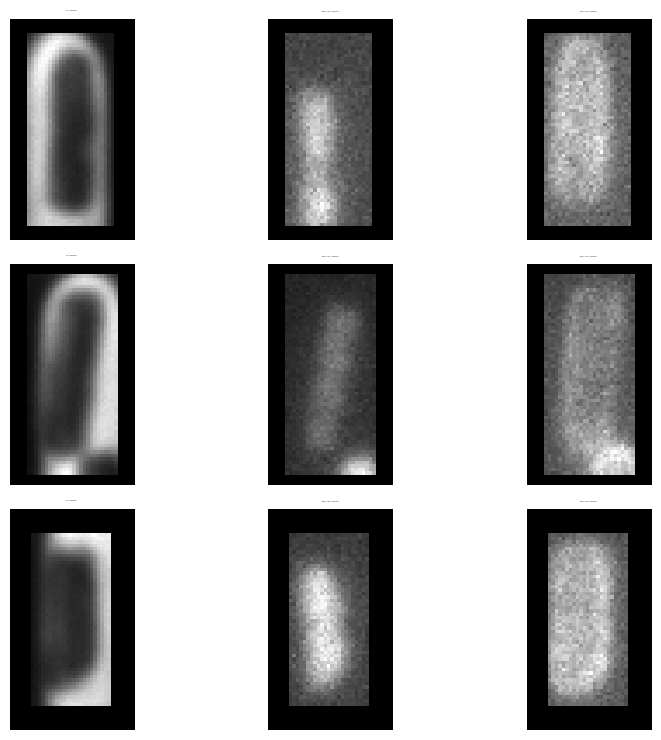

In [2]:
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
barcode = "0110"
basedir = os.getcwd()
data_dir = os.path.join(basedir, f"{barcode}_accepted_mother")
n_examples = 3  # how many cells to show

# --- Helper function for normalization ---
def normalize_image(image):
    image = image.astype(np.float32)
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

# Load Zarr files
files = sorted([f for f in os.listdir(data_dir) if f.endswith('.zarr')])
files = files[:n_examples]  # limit how many to plot

# Create figure: rows = cells, cols = channels
n_rows, n_cols = len(files), 3
plt.figure(figsize=(n_cols * 3, n_rows * 2.5))

for row, fname in enumerate(files):
    path = os.path.join(data_dir, fname)
    g = zarr.open(path, mode='r')
    pc  = g['pc'][...]
    bfp = normalize_image(g['bfp'][...])
    rfp = normalize_image(g['rfp'][...])

    images = [pc, bfp, rfp]
    titles = ['PC', 'BFP (norm)', 'RFP (norm)']

    for col, (img, title) in enumerate(zip(images, titles)):
        ax = plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{title} - {fname}", fontsize=1)
        ax.axis('off')

plt.tight_layout()
plt.show()


## Reject plasmolysed cells

In [ ]:
"""
────────────────────────────────────────────────────────────────────────
1. Segment all PC crops with your Omnipose model
2. Save (filename, area, aspect-ratio) →  barcode_cell_metrics.pkl
3. Plot a 2-D histogram of Area vs Aspect-Ratio
4. Display the k cells nearest to a user-chosen (area, AR) point
────────────────────────────────────────────────────────────────────────
"""

import os, pickle, zarr, math
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from tqdm.auto import tqdm
from scipy.spatial import cKDTree
from cellpose_omni import models, core

barcode   = "1010"
basedir        = os.getcwd()               # root path
src_dir        = os.path.join(basedir, f"{barcode}_accepted_mother")
metrics_pkl    = os.path.join(basedir, f"{barcode}_cell_metrics.pkl")
# ───── USER INPUT ─────
modelpath = r"D:\PRISM\Omnipose_train\SyMBacData\100x_pc_20250510\TD2\models\cellpose_residual_on_style_on_concatenation_off_omni_abstract_nclasses_2_nchan_1_dim_2_TD2_2025_05_10_22_14_11.213998_epoch_149"
params    = {'channels': None, 'rescale': None, 'mask_threshold': -1, 'flow_threshold': 0.,
             'transparency': True, 'omni': True, 'cluster': False, 'resample': True,
             'verbose': 0, 'tile': False, 'niter': None, 'augment': False, 'affinity_seg': False}
# ──────────────────────
model    = models.CellposeModel(gpu=core.use_gpu(), pretrained_model=modelpath, omni=True, concatenation=True)
src_dir  = os.path.join(basedir, f"{barcode}_accepted_mother")
files    = sorted([f for f in os.listdir(src_dir) if f.endswith(".zarr")])

# Query parameters (change and re-run only the last section)
target_area   = 400     # px²
target_ar     = 2.0     # major / minor
k_show        = 6       # how many nearest cells to display
# ───────────────────────────────────────────────────────────────────────


# # ╭──────────────────────────────────────────────────────────────────╮
# # │  STEP 1  – Build / load the (area, aspect) metrics table        │
# # ╰──────────────────────────────────────────────────────────────────╯
if os.path.exists(metrics_pkl):
    print("🔄 Loading cached metrics table …")
    records = pickle.load(open(metrics_pkl, "rb"))
else:
    print("🧩  Metrics cache missing → running Omnipose segmentation once …")
    model = models.CellposeModel(gpu=core.use_gpu(),
                                 pretrained_model=modelpath,
                                 omni=True, concatenation=True)

    records = []
    files = sorted(f for f in os.listdir(src_dir) if f.endswith(".zarr"))

    for fname in tqdm(files, desc="Segmenting"):
        path = os.path.join(src_dir, fname)
        g = zarr.open(path, 'r')

        if 'pc' not in g:
            print(f"⚠️ Skipping {fname} — missing 'pc' channel")
            continue

        pc = g['pc'][...]
        masks, *_ = model.eval(pc, **params)
        masks = masks.astype(np.int32)
        if masks.max() == 0:
            continue

        props = max(regionprops(masks), key=lambda r: r.area)
        area  = props.area
        ar    = props.major_axis_length / props.minor_axis_length if props.minor_axis_length else 0
        records.append((fname, area, ar))


    with open(metrics_pkl, "wb") as fh:
        pickle.dump(records, fh)
    print(f"✅ metrics saved → {metrics_pkl}  ({len(records)} rows)")
    
# Uncomment below if you get errors like ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 50, n_samples_fit = 40, n_samples = 3
# # ╭──────────────────────────────────────────────────────────────────╮
# # │  STEP 1 – Build / load (area, aspect) metrics table (robust v2)  │
# # ╰──────────────────────────────────────────────────────────────────╯
# import omnipose, warnings
# omnipose.core.N_NEIGHBORS = 5          # avoid the 50-NN crash inside Omnipose

# # -----------------------------------------------------------------------------
# # Allowed kwargs for model.eval  – everything else will be stripped out
# ALLOWED = {
#     'channels', 'rescale', 'mask_threshold', 'flow_threshold',
#     'transparency', 'omni', 'cluster', 'resample',
#     'verbose', 'tile', 'niter', 'augment', 'affinity_seg'
# }
# safe_params = {k: v for k, v in params.items() if k in ALLOWED}
# # -----------------------------------------------------------------------------

# if os.path.exists(metrics_pkl):
#     print("🔄  Loading cached metrics table …")
#     with open(metrics_pkl, "rb") as fh:
#         records = pickle.load(fh)

# else:
#     print("🧩  Metrics cache missing → running Omnipose segmentation …")

#     model = models.CellposeModel(
#         gpu=core.use_gpu(),
#         pretrained_model=modelpath,
#         omni=True,
#         concatenation=True
#     )

#     records = []
#     files = sorted(f for f in os.listdir(src_dir) if f.endswith(".zarr"))

#     for fname in tqdm(files, desc="Segmenting"):
#         path = os.path.join(src_dir, fname)
#         g = zarr.open(path, 'r')

#         if 'pc' not in g:
#             warnings.warn(f"{fname}: no 'pc' channel — skipped")
#             continue

#         try:
#             masks, *_ = model.eval(g['pc'][...], **safe_params)
#         except ValueError as e:
#             warnings.warn(f"{fname}: {e} — skipped")
#             continue

#         masks = masks.astype(np.int32)
#         if masks.max() == 0:
#             continue

#         p   = max(regionprops(masks), key=lambda r: r.area)
#         area = p.area
#         ar   = (p.major_axis_length / p.minor_axis_length
#                 if p.minor_axis_length else 0)
#         records.append((fname, area, ar))

#     # save cache for next run
#     with open(metrics_pkl, "wb") as fh:
#         pickle.dump(records, fh)
#     print(f"✅ metrics saved → {metrics_pkl}  ({len(records)} rows)")




2025-05-23 21:49:35,866 [INFO] ** TORCH GPU version installed and working. **
2025-05-23 21:49:35,868 [INFO] ** TORCH GPU version installed and working. **
2025-05-23 21:49:35,869 [INFO] >>>> using GPU
🔄 Loading cached metrics table …


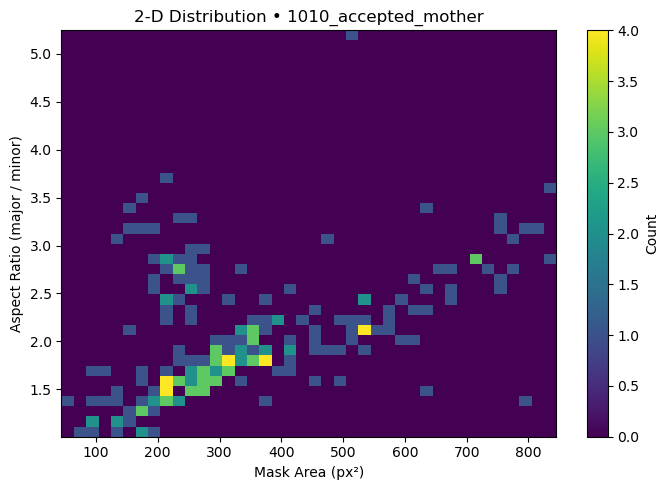

In [21]:

# ╭──────────────────────────────────────────────────────────────────╮
# │  STEP 2 – Distribution plot                                      │
# ╰──────────────────────────────────────────────────────────────────╯
fn   = np.array([r[0] for r in records])
area = np.array([r[1] for r in records], float)
ar   = np.array([r[2] for r in records], float)

plt.figure(figsize=(7, 5))
plt.hist2d(area, ar, bins=[40, 40], cmap="viridis")
plt.xlabel("Mask Area (px²)");  plt.ylabel("Aspect Ratio (major / minor)")
plt.title(f"2-D Distribution • {barcode}_accepted_mother")
plt.colorbar(label="Count");  plt.tight_layout();  plt.show()




Closest matches:
T0468.zarr       area=  714  AR=2.88
T0236.zarr       area=  679  AR=2.41
T0047.zarr       area=  724  AR=2.82
T0165.zarr       area=  724  AR=2.89
T0126.zarr       area=  673  AR=2.79
T0039.zarr       area=  672  AR=2.55
T0053.zarr       area=  729  AR=2.70
T0368.zarr       area=  658  AR=2.78


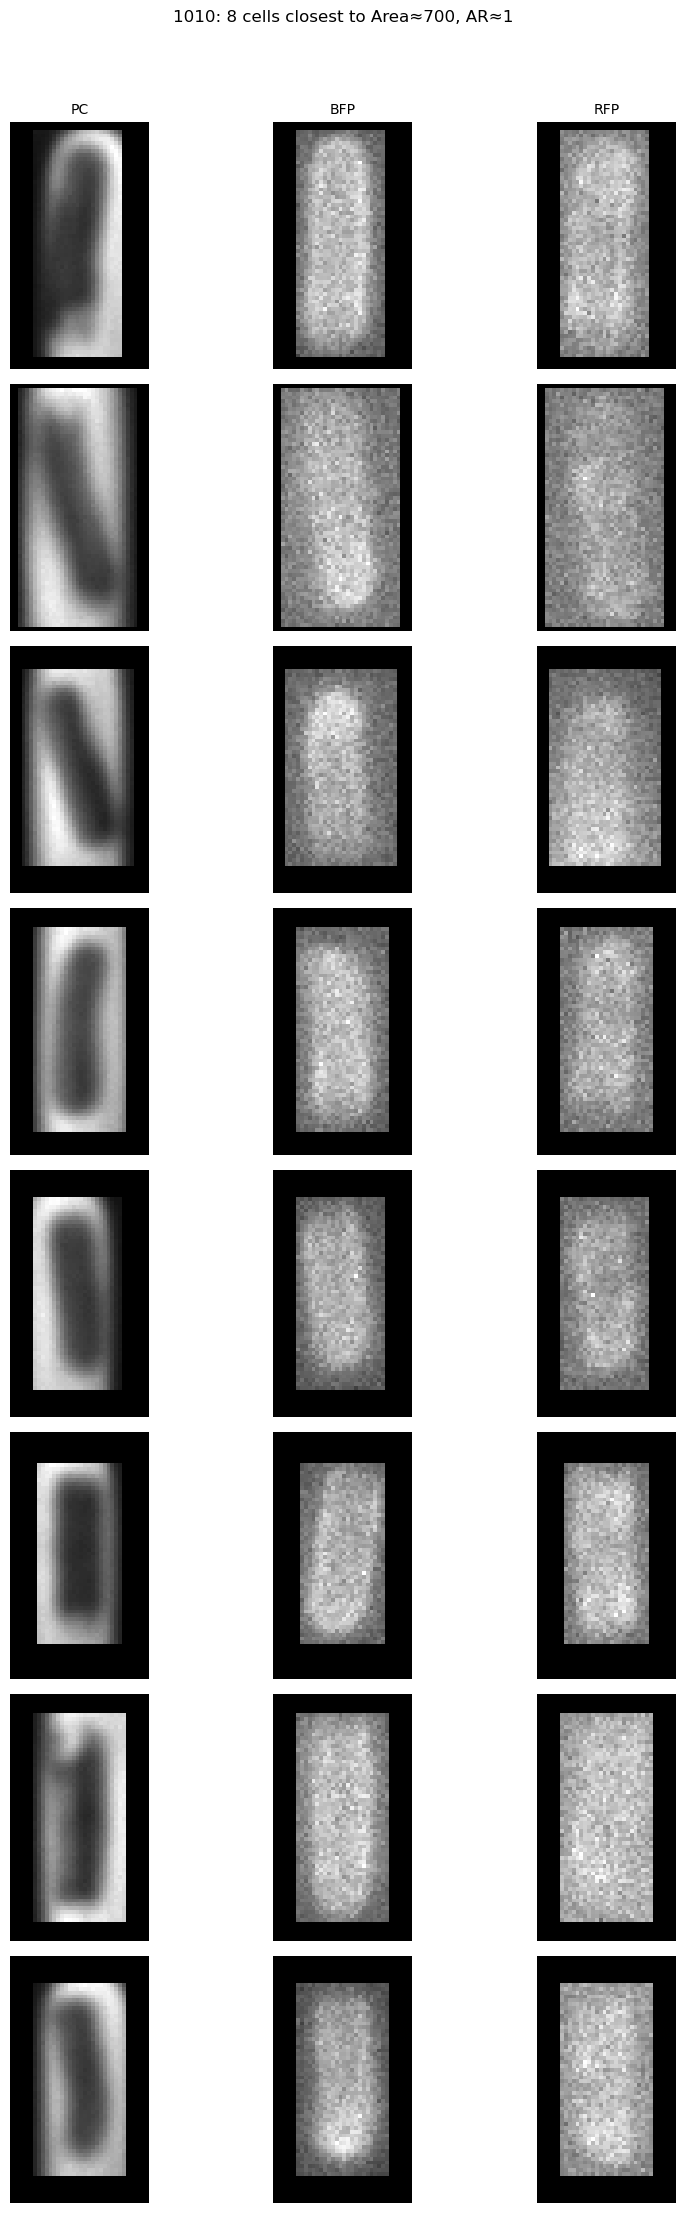

In [28]:
from scipy.spatial import cKDTree

# ─── Parameters ───
target_area = 700     # px²
target_ar   = 1    # major/minor
k_show      = 8      # how many cells to display
cols        = 3       # PC, BFP, RFP per cell

# ─── Query Nearest ───
tree = cKDTree(np.column_stack([area, ar]))
_, idx = tree.query([target_area, target_ar], k=k_show)

print("\nClosest matches:")
for i in idx:
    print(f"{fn[i]:<15}  area={area[i]:5.0f}  AR={ar[i]:.2f}")

def norm(im):
    im = im.astype(float)
    return (im - im.min()) / (im.ptp() + 1e-8)

# ─── Plot: rows = cells, cols = PC/BFP/RFP ───
rows = k_show
plt.figure(figsize=(cols * 3, rows * 3))

for r, i in enumerate(idx):
    g = zarr.open(os.path.join(src_dir, fn[i]), 'r')
    pc  = norm(g['pc'][...])
    bfp = norm(g['bfp'][...])
    rfp = norm(g['rfp'][...])

    images = [pc, bfp, rfp]
    titles = ["PC", "BFP", "RFP"]

    for c in range(cols):
        ax = plt.subplot(rows, cols, r * cols + c + 1)
        ax.imshow(images[c], cmap='gray')
        if r == 0:
            ax.set_title(titles[c], fontsize=10)
        if c == 0:
            ax.set_ylabel(f"{fn[i]}\nA={area[i]:.0f}, AR={ar[i]:.2f}", fontsize=8)
        ax.axis('off')

plt.suptitle(f"{barcode}: {k_show} cells closest to Area≈{target_area}, AR≈{target_ar}",
             y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


In [43]:
# Count cells with area > 400
threshold = 600
n_total = len(area)
n_large = np.sum(area > threshold)
fraction_large = n_large / n_total

print(f"📊 Total cells       : {n_total}")
print(f"📈 Cells > {threshold:>3} px² : {n_large}")
print(f"✅ Fraction above threshold : {fraction_large:.2%}")


📊 Total cells       : 81
📈 Cells > 600 px² : 43
✅ Fraction above threshold : 53.09%


In [44]:
# ╭──────────────────────────────────────────────────────────────────╮
# │  STEP 3 – Write filtered crops to  <barcode>_clear_mother/       │
# ╰──────────────────────────────────────────────────────────────────╯
import shutil, tqdm

min_area_thresh = threshold         # ▼ keep cells with area ≥ 400 px²
dst_dir = os.path.join(basedir, f"{barcode}_clear_mother")
os.makedirs(dst_dir, exist_ok=True)

kept, skipped = 0, 0
for fname, a, _ in tqdm.tqdm(records, desc="Filtering by area"):
    if a >= min_area_thresh:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(dst):
            shutil.copytree(src, dst)      # copies datasets + attributes
        kept += 1
    else:
        skipped += 1

print(f"\n✅ Wrote {kept} cells (area ≥ {min_area_thresh}) to {dst_dir}")
print(f"🗑️  Skipped {skipped} cells below threshold")


Filtering by area: 100%|██████████| 81/81 [00:02<00:00, 27.53it/s]


✅ Wrote 43 cells (area ≥ 600) to d:\PRISM\1001_clear_mother
🗑️  Skipped 38 cells below threshold


## Statistics across experiments/barcodes

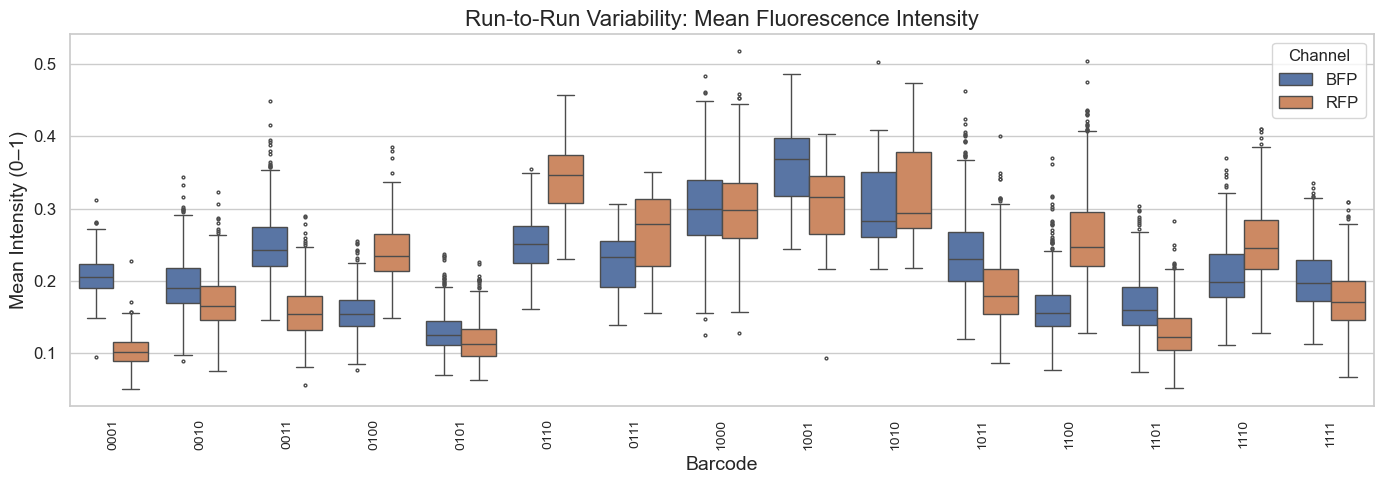

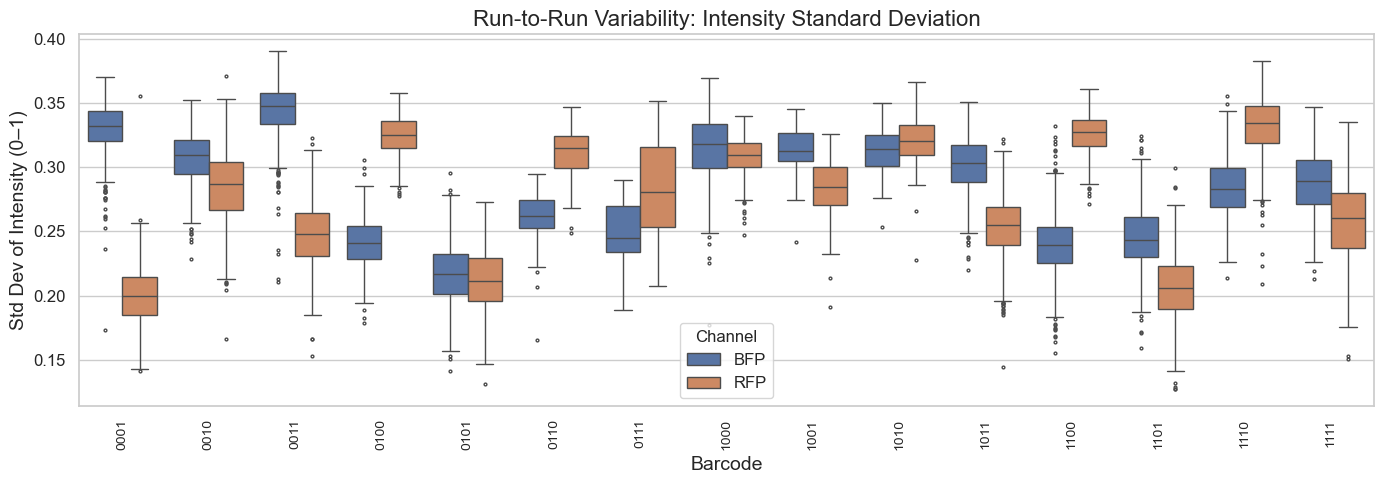

In [1]:
import os
import zarr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1) Load & aggregate statistics ──────────────────────────────────
base_dir = os.getcwd()   # adjust to your data root
barcodes = [f"{i:04b}" for i in range(16)]
channels = ['bfp','rfp']

records = []
for bc in barcodes:
    src = os.path.join(base_dir, f"{bc}_clear_mother")
    if not os.path.isdir(src):
        continue
    for fn in sorted(os.listdir(src)):
        if not fn.endswith('.zarr'):
            continue
        g = zarr.open(os.path.join(src, fn), mode='r')
        for ch in channels:
            if ch in g.array_keys():
                img = g[ch][...].astype(np.float32)
                # normalize to [0,1]
                img = (img - img.min()) / (img.max() - img.min() + 1e-12)
                records.append({
                    'barcode': bc,
                    'channel': ch.upper(),
                    'mean_intensity': img.mean(),
                    'std_intensity': img.std()
                })

df = pd.DataFrame(records)

# ── 2) Seaborn settings ─────────────────────────────────────────────
sns.set_theme(style="whitegrid")
palette = {"BFP":"C0","RFP":"C1"}
barorder = sorted(df['barcode'].unique())

# ── 3) Plot Mean Intensity ─────────────────────────────────────────
plt.figure(figsize=(14,5))
ax = sns.boxplot(
    data=df, x='barcode', y='mean_intensity', hue='channel',
    order=barorder, palette=palette, fliersize=2, linewidth=1
)
ax.set_xlabel("Barcode", fontsize=14)
ax.set_ylabel("Mean Intensity (0–1)", fontsize=14)
ax.set_title("Run-to-Run Variability: Mean Fluorescence Intensity", fontsize=16)
ax.tick_params(axis='x', rotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title="Channel", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()

# ── 4) Plot Std Dev of Intensity ────────────────────────────────────
plt.figure(figsize=(14,5))
ax = sns.boxplot(
    data=df, x='barcode', y='std_intensity', hue='channel',
    order=barorder, palette=palette, fliersize=2, linewidth=1
)
ax.set_xlabel("Barcode", fontsize=14)
ax.set_ylabel("Std Dev of Intensity (0–1)", fontsize=14)
ax.set_title("Run-to-Run Variability: Intensity Standard Deviation", fontsize=16)
ax.tick_params(axis='x', rotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title="Channel", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()


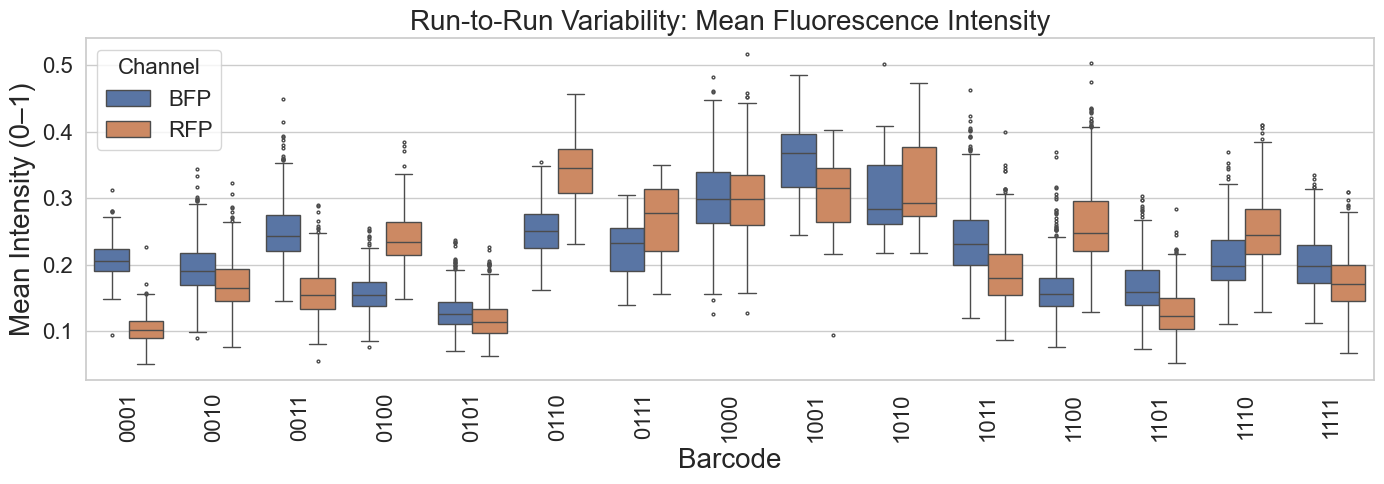

In [2]:
# ── 3) Plot Mean Intensity ─────────────────────────────────────────
plt.figure(figsize=(14,5))
ax = sns.boxplot(
    data=df, x='barcode', y='mean_intensity', hue='channel',
    order=barorder, palette=palette, fliersize=2, linewidth=1
)
ax.set_xlabel("Barcode", fontsize=20)
ax.set_ylabel("Mean Intensity (0–1)", fontsize=20)
ax.set_title("Run-to-Run Variability: Mean Fluorescence Intensity", fontsize=20)
ax.tick_params(axis='x', rotation=90, labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(title="Channel", fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.show()


In [4]:
# find the number of cells before and after rejection
import os
import re
import pandas as pd

# 1) Find all clear‐mother and accepted‐mother folders under cwd
clear_dirs    = {}
accepted_dirs = {}
for root, dirs, _ in os.walk(os.getcwd()):
    for d in dirs:
        if re.fullmatch(r"[01]{4}_clear_mother", d):
            bc = d.split("_")[0]
            clear_dirs[bc] = os.path.join(root, d)
        elif re.fullmatch(r"[01]{4}_accepted_mother", d):
            bc = d.split("_")[0]
            accepted_dirs[bc] = os.path.join(root, d)

# 2) Count cells BEFORE rejection (one .zarr per cell)
before_counts = {}
for bc, folder in sorted(clear_dirs.items()):
    files = [f for f in os.listdir(folder) if f.endswith(".zarr")]
    before_counts[bc] = len(files)

# 3) Count cells AFTER rejection (max trench index + 1)
pattern = re.compile(r"^T(\d{4})\.zarr$")
after_counts = {}
for bc, folder in sorted(accepted_dirs.items()):
    max_idx = -1
    for fname in os.listdir(folder):
        m = pattern.match(fname)
        if m:
            idx = int(m.group(1))
            if idx > max_idx:
                max_idx = idx
    after_counts[bc] = (max_idx + 1) if max_idx >= 0 else 0

# 4) Build table and report
df = pd.DataFrame({
    "Before Rejection": before_counts,
    "After Rejection": after_counts,
})
df.index.name = "Barcode"
df["Delta"] = df["Before Rejection"] - df["After Rejection"]
df.loc["Total"] = df.sum(numeric_only=True)

# 5) Print as markdown table
print(df.to_markdown())


| Barcode   |   Before Rejection |   After Rejection |   Delta |
|:----------|-------------------:|------------------:|--------:|
| 0001      |                437 |               443 |      -6 |
| 0010      |                351 |               446 |     -95 |
| 0011      |                487 |               503 |     -16 |
| 0100      |                415 |               445 |     -30 |
| 0101      |                492 |               504 |     -12 |
| 0110      |                 68 |               563 |    -495 |
| 0111      |                 23 |               414 |    -391 |
| 1000      |                432 |               519 |     -87 |
| 1001      |                 43 |               588 |    -545 |
| 1010      |                 51 |               590 |    -539 |
| 1011      |                550 |               600 |     -50 |
| 1100      |                659 |               950 |    -291 |
| 1101      |                559 |               572 |     -13 |
| 1110      |            

## Make Train/Test dataset

Make zarr array of mother cells for each clour and class

In [ ]:
# To make train/test set by 6:4 split for PRISM setup 1, use all barcodes for training
import os
import zarr
import numpy as np
from tqdm.auto import tqdm

# ────────────────────────────────────────────────────────────────────────
# Paths
basedir   = os.getcwd()
src_root  = basedir  # where the *_clear_mother dirs live
dst_root = os.path.join(basedir, "Test All")
test_root = os.path.join(dst_root, "test_sets")
os.makedirs(dst_root,  exist_ok=True)
os.makedirs(test_root, exist_ok=True)

# Mapping for the 6 “coloured” sets
DEST_NAME = {
    ("BFP", "10"): "BFP_membrane_mc",
    ("BFP", "01"): "BFP_nucleoid_mc",
    ("BFP", "11"): "BFP_both_mc",
    ("RFP", "10"): "RFP_membrane_mc",
    ("RFP", "01"): "RFP_nucleoid_mc",
    ("RFP", "11"): "RFP_both_mc",
}

# Background folders
BG_FOLDERS = {
    "BFP": "BFP_background_mc",
    "RFP": "RFP_background_mc",
}

# Create all 8 train subfolders + test folder
all_train_folders = list(DEST_NAME.values()) + list(BG_FOLDERS.values())
for f in all_train_folders:
    os.makedirs(os.path.join(dst_root, f), exist_ok=True)

# Counters for naming
counters = {f: 0 for f in all_train_folders}
test_counts = {}

# Helper to find barcode dir
def norm_path(bc):
    d = os.path.join(src_root, f"{bc}_clear_mother")
    return d if os.path.isdir(d) else None

# All 4-bit barcodes
barcodes = [f"{i:04b}" for i in range(16)]
rng = np.random.RandomState(123)

for bc in tqdm(barcodes, desc="Barcodes"):
    src_dir = norm_path(bc)
    if src_dir is None:
        continue

    # list all cell .zarr dirs
    cells = sorted([d for d in os.listdir(src_dir) if d.endswith(".zarr")])
    if not cells:
        continue

    rng.shuffle(cells)
    n_test = max(1, int(0.4 * len(cells)))
    test_cells = cells[:n_test]
    train_cells = cells[n_test:]

    test_counts[bc] = len(test_cells)

    # ——— 1) write out {bc}_test.zarr containing all channels ———————
    if test_cells:
        bfp_stack = []
        rfp_stack = []
        for cell in test_cells:
            g = zarr.open(os.path.join(src_dir, cell), "r")
            if "bfp" in g.array_keys():
                bfp_stack.append(g["bfp"][...])
            if "rfp" in g.array_keys():
                rfp_stack.append(g["rfp"][...])

        out_test = os.path.join(test_root, f"{bc}_test.zarr")
        gd = zarr.open(out_test, mode="w")
        if bfp_stack:
            gd.create_dataset("bfp",
                              data=np.stack(bfp_stack,  axis=0),
                              chunks=True)
        if rfp_stack:
            gd.create_dataset("rfp",
                              data=np.stack(rfp_stack,  axis=0),
                              chunks=True)

    # pre-compute codes
    bfp_code, rfp_code = bc[:2], bc[2:]

    # ——— 2) pipeline over the training cells (only barcodes ≥100) ——
    for cell in train_cells:
        g = zarr.open(os.path.join(src_dir, cell), "r")

        # coloured pipelines for codes 10,01,11
        for colour, code in (("BFP", bfp_code), ("RFP", rfp_code)):
            if code in {"10", "01", "11"}:
                key = colour.lower()
                sub = DEST_NAME[(colour, code)]
                arr = g[key][...]
                out_z = os.path.join(dst_root, sub, f"C{counters[sub]:06d}.zarr")
                counters[sub] += 1
                gd = zarr.open(out_z, mode="w")
                gd.create_dataset(key, data=arr, chunks=True)

        # background pipelines for code == "00"
        if bfp_code == "00" and "bfp" in g.array_keys():
            sub = BG_FOLDERS["BFP"]
            arr = g["bfp"][...]
            out_z = os.path.join(dst_root, sub, f"C{counters[sub]:06d}.zarr")
            counters[sub] += 1
            gd = zarr.open(out_z, mode="w")
            gd.create_dataset("bfp", data=arr, chunks=True)

        if rfp_code == "00" and "rfp" in g.array_keys():
            sub = BG_FOLDERS["RFP"]
            arr = g["rfp"][...]
            out_z = os.path.join(dst_root, sub, f"C{counters[sub]:06d}.zarr")
            counters[sub] += 1
            gd = zarr.open(out_z, mode="w")
            gd.create_dataset("rfp", data=arr, chunks=True)

# ────────────────────────────────────────────────────────────────────────
# Report
print("\n✅ Test split counts:")
for bc, n in test_counts.items():
    print(f"  Barcode {bc}: {n} cells → test")

print("\n✅ Training collections built:")
for sub, cnt in counters.items():
    print(f"  {sub:<20}: {cnt} cells")


Barcodes:   0%|          | 0/16 [00:00<?, ?it/s]


✅ Test split counts:
  Barcode 0001: 437 cells → test
  Barcode 0010: 351 cells → test
  Barcode 0011: 487 cells → test
  Barcode 0100: 415 cells → test
  Barcode 0101: 492 cells → test
  Barcode 0110: 68 cells → test
  Barcode 0111: 23 cells → test
  Barcode 1000: 432 cells → test
  Barcode 1001: 43 cells → test
  Barcode 1010: 51 cells → test
  Barcode 1011: 550 cells → test
  Barcode 1100: 659 cells → test
  Barcode 1101: 559 cells → test
  Barcode 1110: 406 cells → test
  Barcode 1111: 564 cells → test

✅ Training collections built:
  BFP_membrane_mc     : 0 cells
  BFP_nucleoid_mc     : 0 cells
  BFP_both_mc         : 0 cells
  RFP_membrane_mc     : 0 cells
  RFP_nucleoid_mc     : 0 cells
  RFP_both_mc         : 0 cells
  BFP_background_mc   : 0 cells
  RFP_background_mc   : 0 cells


In [ ]:
# For PRISM setup 3 and 4, use 8 barcodes for training and other 8 for testing.
import os
import zarr
import numpy as np
from tqdm.auto import tqdm

# ────────────────────────────────────────────────────────────────────────
# Paths
basedir   = os.getcwd()
dst_root  = os.path.join(basedir, "General_Test_PRISM")
test_root = os.path.join(dst_root, "test_sets")
os.makedirs(dst_root,  exist_ok=True)
os.makedirs(test_root, exist_ok=True)

# Mapping for the 6 “coloured” sets
DEST_NAME = {
    ("BFP", "10"): "BFP_membrane_mc",
    ("BFP", "01"): "BFP_nucleoid_mc",
    ("BFP", "11"): "BFP_both_mc",
    ("RFP", "10"): "RFP_membrane_mc",
    ("RFP", "01"): "RFP_nucleoid_mc",
    ("RFP", "11"): "RFP_both_mc",
}

# Background folders
BG_FOLDERS = {
    "BFP": "BFP_background_mc",
    "RFP": "RFP_background_mc",
}

# Create all 8 train subfolders
all_train_folders = list(DEST_NAME.values()) + list(BG_FOLDERS.values())
for f in all_train_folders:
    os.makedirs(os.path.join(dst_root, f), exist_ok=True)

# Counters for naming
counters = {f: 0 for f in all_train_folders}
test_counts = {}

# Helper to find barcode dir
def norm_path(bc):
    d = os.path.join(basedir, f"{bc}_clear_mother")
    return d if os.path.isdir(d) else None

# All 4-bit barcodes
barcodes = [f"{i:04b}" for i in range(16)]

# Only these 8 barcodes go to TRAIN
train_barcodes = {
    "0001","0011","0101","0110",
    "1001","0111","1100","1101"
}

for bc in tqdm(barcodes, desc="Barcodes"):
    src_dir = norm_path(bc)
    if src_dir is None:
        continue

    # list all cell .zarr dirs
    cells = sorted([d for d in os.listdir(src_dir) if d.endswith(".zarr")])
    if not cells:
        continue

    # split based on barcode membership
    if bc in train_barcodes:
        train_cells = cells[:]   # all to train
        test_cells  = []
    else:
        train_cells = []
        test_cells  = cells[:]   # all to test

    test_counts[bc] = len(test_cells)

    # ——— write out {bc}_test.zarr containing all channels ———————
    if test_cells:
        bfp_stack = []
        rfp_stack = []
        for cell in test_cells:
            g = zarr.open(os.path.join(src_dir, cell), "r")
            if "bfp" in g.array_keys():
                bfp_stack.append(g["bfp"][...])
            if "rfp" in g.array_keys():
                rfp_stack.append(g["rfp"][...])

        out_test = os.path.join(test_root, f"{bc}_test.zarr")
        gd = zarr.open(out_test, mode="w")
        if bfp_stack:
            gd.create_dataset("bfp",
                              data=np.stack(bfp_stack,  axis=0),
                              chunks=True)
        if rfp_stack:
            gd.create_dataset("rfp",
                              data=np.stack(rfp_stack,  axis=0),
                              chunks=True)

    # pre-compute channel codes
    bfp_code, rfp_code = bc[:2], bc[2:]

    # ——— pipeline over the training cells ——
    for cell in train_cells:
        g = zarr.open(os.path.join(src_dir, cell), "r")

        # coloured pipelines for codes 10,01,11
        for colour, code in (("BFP", bfp_code), ("RFP", rfp_code)):
            if code in {"10", "01", "11"}:
                key = colour.lower()
                sub = DEST_NAME[(colour, code)]
                arr = g[key][...]
                out_z = os.path.join(dst_root, sub,
                                     f"C{counters[sub]:06d}.zarr")
                counters[sub] += 1
                gd = zarr.open(out_z, mode="w")
                gd.create_dataset(key, data=arr, chunks=True)

        # background pipelines for code == "00"
        if bfp_code == "00" and "bfp" in g.array_keys():
            sub = BG_FOLDERS["BFP"]
            arr = g["bfp"][...]
            out_z = os.path.join(dst_root, sub,
                                 f"C{counters[sub]:06d}.zarr")
            counters[sub] += 1
            gd = zarr.open(out_z, mode="w")
            gd.create_dataset("bfp", data=arr, chunks=True)

        if rfp_code == "00" and "rfp" in g.array_keys():
            sub = BG_FOLDERS["RFP"]
            arr = g["rfp"][...]
            out_z = os.path.join(dst_root, sub,
                                 f"C{counters[sub]:06d}.zarr")
            counters[sub] += 1
            gd = zarr.open(out_z, mode="w")
            gd.create_dataset("rfp", data=arr, chunks=True)

# ────────────────────────────────────────────────────────────────────────
# Report
print("\n✅ Test‐set counts by barcode:")
for bc, n in test_counts.items():
    print(f"  Barcode {bc}: {n} cells → test")

print("\n✅ Training collections built:")
for sub, cnt in counters.items():
    print(f"  {sub:<20}: {cnt} cells")


Barcodes:   0%|          | 0/16 [00:00<?, ?it/s]


✅ Test‐set counts by barcode:
  Barcode 0001: 0 cells → test
  Barcode 0010: 351 cells → test
  Barcode 0011: 0 cells → test
  Barcode 0100: 415 cells → test
  Barcode 0101: 0 cells → test
  Barcode 0110: 0 cells → test
  Barcode 0111: 0 cells → test
  Barcode 1000: 432 cells → test
  Barcode 1001: 0 cells → test
  Barcode 1010: 51 cells → test
  Barcode 1011: 550 cells → test
  Barcode 1100: 0 cells → test
  Barcode 1101: 0 cells → test
  Barcode 1110: 406 cells → test
  Barcode 1111: 564 cells → test

✅ Training collections built:
  BFP_membrane_mc     : 43 cells
  BFP_nucleoid_mc     : 583 cells
  BFP_both_mc         : 1218 cells
  RFP_membrane_mc     : 68 cells
  RFP_nucleoid_mc     : 1531 cells
  RFP_both_mc         : 510 cells
  BFP_background_mc   : 924 cells
  RFP_background_mc   : 659 cells


Merge same class across colours: make M, N, MN, None dataset for training data

In [ ]:


import os
import zarr
from tqdm.auto import tqdm

# ─── CONFIG ──────────────────────────────────────────────────────────
basedir  = os.getcwd()
# src_root = os.path.join(basedir, "Mother Cell For PRISM Train")
src_root = os.path.join(basedir, "Test All")
dst_root = os.path.join(src_root, "merged")
os.makedirs(dst_root, exist_ok=True)

# For each merged class, list the source folders to pull from:
MERGE_MAP = {
    "Membrane_only_mc":    ["BFP_membrane_mc",    "RFP_membrane_mc"],
    "Nucleoid_only_mc":    ["BFP_nucleoid_mc",    "RFP_nucleoid_mc"],
    "Both_mc":             ["BFP_both_mc",        "RFP_both_mc"],
    "Background_mc":       ["BFP_background_mc",  "RFP_background_mc"],
}

# ─── MERGE ───────────────────────────────────────────────────────────
for merged_name, src_folders in MERGE_MAP.items():
    dst_dir = os.path.join(dst_root, merged_name)
    os.makedirs(dst_dir, exist_ok=True)
    count = 0

    for src in src_folders:
        src_dir = os.path.join(src_root, src)
        if not os.path.isdir(src_dir):
            print(f"⚠️  Skipping missing folder: {src_dir}")
            continue

        for zf in tqdm(sorted(os.listdir(src_dir)),
                       desc=f"Merging {src} → {merged_name}",
                       leave=False):
            if not zf.endswith(".zarr"):
                continue

            # read source
            src_path = os.path.join(src_dir, zf)
            g = zarr.open(src_path, mode="r")

            # pick whichever channel exists
            # (for your eight input sets, each zarr has only one of 'bfp' or 'rfp')
            keys = [k for k in g.array_keys() if k in ("bfp", "rfp")]
            if not keys:
                print(f"⚠️  No bfp/rfp in {zf}, skipping")
                continue

            chan = g[keys[0]][...]

            # write to merged/{merged_name}/C{count:06d}.zarr under key "chan"
            out_path = os.path.join(dst_dir, f"C{count:06d}.zarr")
            gd = zarr.open(out_path, mode="w")
            gd.create_dataset("chan", data=chan, chunks=True)

            count += 1

    print(f"✅  {merged_name}: {count} images written → {dst_dir}")

print("\n🎉  All merged datasets completed.")


Merging BFP_membrane_mc → Membrane_only_mc:   0%|          | 0/43 [00:00<?, ?it/s]

Merging RFP_membrane_mc → Membrane_only_mc:   0%|          | 0/68 [00:00<?, ?it/s]

✅  Membrane_only_mc: 111 images written → d:\PRISM\General_Test_PRISM\merged\Membrane_only_mc


Merging BFP_nucleoid_mc → Nucleoid_only_mc:   0%|          | 0/583 [00:00<?, ?it/s]

Merging RFP_nucleoid_mc → Nucleoid_only_mc:   0%|          | 0/1531 [00:00<?, ?it/s]

✅  Nucleoid_only_mc: 2114 images written → d:\PRISM\General_Test_PRISM\merged\Nucleoid_only_mc


Merging BFP_both_mc → Both_mc:   0%|          | 0/1218 [00:00<?, ?it/s]

Merging RFP_both_mc → Both_mc:   0%|          | 0/510 [00:00<?, ?it/s]

✅  Both_mc: 1728 images written → d:\PRISM\General_Test_PRISM\merged\Both_mc


Merging BFP_background_mc → Background_mc:   0%|          | 0/924 [00:00<?, ?it/s]

Merging RFP_background_mc → Background_mc:   0%|          | 0/659 [00:00<?, ?it/s]

✅  Background_mc: 1583 images written → d:\PRISM\General_Test_PRISM\merged\Background_mc

🎉  All merged datasets completed.


Currently turn all image into train set but can hold out test (validation) set by changing param valid_ratio.

In [12]:
#!/usr/bin/env python3
import os
import zarr
import pickle
import numpy as np
from tqdm.auto import tqdm

# ─── Paths ─────────────────────────────────────────────────────────
BASE    = os.getcwd()
# MERGED  = os.path.join(BASE, "Mother Cell For PRISM Train", "merged")
MERGED  = os.path.join(BASE, "General_Test_PRISM", "merged")
OUTDIR  = os.path.join(MERGED, "CNN_dataset")
os.makedirs(OUTDIR, exist_ok=True)

# ─── Class → label mapping ─────────────────────────────────────────
CLASS_FOLDERS = {
    "Background_mc":     0,
    "Membrane_only_mc":  1,
    "Nucleoid_only_mc":  2,
    "Both_mc":           3,
}
valid_ratio = 0
# ─── 1) Gather images by class ────────────────────────────────────
class_data = {cls: [] for cls in CLASS_FOLDERS}
for cls_name, lbl in CLASS_FOLDERS.items():
    folder = os.path.join(MERGED, cls_name)
    if not os.path.isdir(folder):
        continue
    for zf in sorted(os.listdir(folder)):
        if not zf.endswith(".zarr"):
            continue
        path = os.path.join(folder, zf)
        z = zarr.open(path, mode="r")
        if "chan" not in z.array_keys():
            raise KeyError(f"‘chan’ missing in {path}")
        img = z["chan"][...]
        class_data[cls_name].append((img, lbl))

# ─── 2) Compute per-class test counts, align to the smallest ───────
counts      = {cls: len(v) for cls, v in class_data.items()}
test_counts = {cls: int(np.floor(valid_ratio * c)) for cls, c in counts.items()}
min_test    = min(test_counts.values())

print("Per-class total images:", counts)
# print("Per-class 30% floor:", test_counts)
# print("→ enforcing test size =", min_test, "images per class")

# ─── 3) Split each class into train/test ──────────────────────────
rng      = np.random.RandomState(42)
train, test = [], []
for cls_name, items in class_data.items():
    rng.shuffle(items)
    test_items  = items[:min_test]
    train_items = items[min_test:]
    test .extend(test_items)
    train.extend(train_items)

print(f"\nFinal counts → train: {len(train)}   validation: {len(test)}")

# ─── 4) Separate images & labels & normalize test only ───────────
def normalize(im):
    im = im.astype(np.float32)
    return (im - im.min()) / (im.ptp() + 1e-8)

train_imgs, train_lbls = zip(*train)
# test_imgs,  test_lbls  = zip(*test)

# test_imgs = [normalize(im) for im in test_imgs]

# ─── 5) Save to pickle ────────────────────────────────────────────
with open(os.path.join(OUTDIR, "train.pkl"), "wb") as f:
    pickle.dump((list(train_imgs), list(train_lbls)), f)

# with open(os.path.join(OUTDIR, "test.pkl"), "wb") as f:
#     pickle.dump((test_imgs,  list(test_lbls)),  f)

# ─── Summary ─────────────────────────────────────────────────────
print(f"\nSaved:")
print(f" • {len(train)} training images → {OUTDIR}/train.pkl   (unnormalized)")
# print(f" • {len(test)}  test     images → {OUTDIR}/test.pkl    (normalized)")


Per-class total images: {'Background_mc': 1583, 'Membrane_only_mc': 111, 'Nucleoid_only_mc': 2114, 'Both_mc': 1728}

Final counts → train: 5536   validation: 0

Saved:
 • 5536 training images → d:\PRISM\General_Test_PRISM\merged\CNN_dataset/train.pkl   (unnormalized)


## Augumentation for training set

| Augmentation        | Controlled By                     | Range / Type     | Probability |
| ------------------- | --------------------------------- | ---------------- | ----------- |
| Rotation            | `angle`                           | `[-180°, 180°]`  | 50%         |
| Flip (horizontal)   | `tf.image.random_flip_left_right` | binary           | 50%         |
| Flip (vertical)     | `tf.image.random_flip_up_down`    | binary           | 50%         |
| Shift               | `shift_fraction_y/x`              | `[-0.1, 0.1]`    | 50%         |
| Uneven Lighting   | `num_control_points`              | 5 points         | 20%         |
| Contrast Warp      | `num_control_points`              | 1 point         | 20%         |
| Brightness/Contrast | `max_delta`, contrast range       | 0.1, \[0.9, 1.1] | 50%         |
| Gaussian Noise      | `stddev`                          | `[0, 0.07]`      | 50%         |
| Gaussian Blur       | `σ`                               | `[0, 0.5]`       | 30%         |


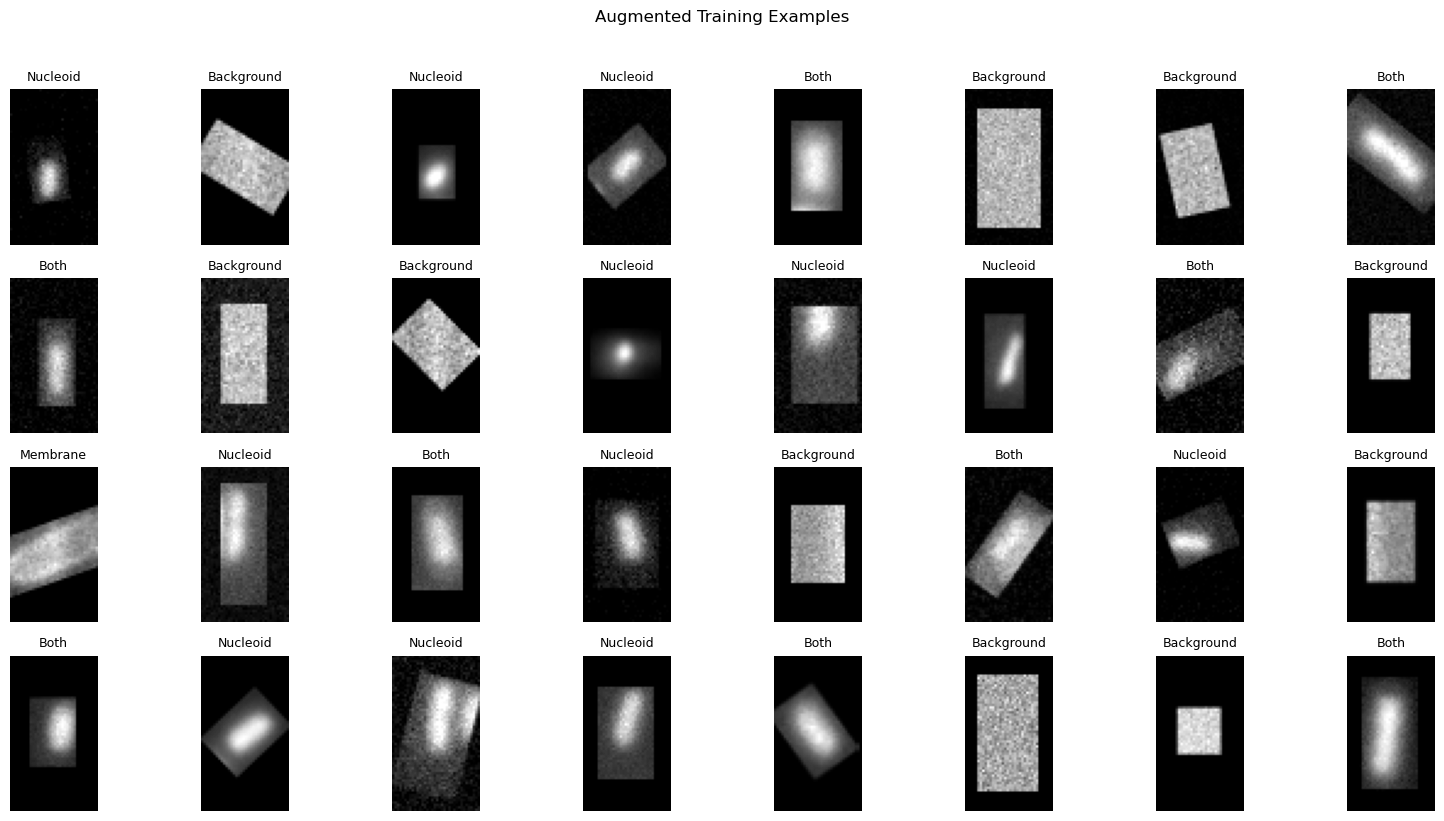

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.ndimage import rotate, shift

# --- Augmentation functions (as defined previously) ------------------
def tf_rotate(image, angle, order=1):
    def rotate_image(image, angle, order):
        image_np = image.numpy()
        return rotate(image_np, angle, axes=(0, 1), reshape=False, mode="nearest", order=order)
    image_rotated = tf.py_function(rotate_image, [image, angle, order], tf.float32)
    image_rotated.set_shape(image.get_shape())
    return image_rotated

def tf_illumination_voodoo(image, num_control_points=5):
    image = tf.cast(image, tf.float32)
    control_points = tf.linspace(0.0, tf.cast(tf.shape(image)[1], tf.float32) - 1.0, num_control_points)
    random_points = tf.random.uniform([num_control_points], minval=0.78, maxval=1.22)
    interp_points = tf.linspace(0.0, tf.cast(tf.shape(image)[1], tf.float32) - 1.0, tf.shape(image)[1])
    curve = tfp.math.interp_regular_1d_grid(
        interp_points,
        control_points[0],
        control_points[-1],
        random_points,
        fill_value="constant_extension",
    )
    curve = tf.reshape(curve, [1, -1, 1])
    curve = tf.tile(curve, [tf.shape(image)[0], 1, tf.shape(image)[2]])
    return image * curve

def tf_histogram_voodoo(image, num_control_points=1):
    original_points = tf.linspace(0.0, 1.0, num=num_control_points + 2)
    target_points = tf.linspace(0.0, 1.0, num=num_control_points + 2)
    random_values = tf.random.uniform([num_control_points], 0.35, 0.65)
    sorted_random = tf.sort(random_values)
    target_points = tf.tensor_scatter_nd_update(
        target_points,
        tf.reshape(tf.range(1, num_control_points + 1), [-1, 1]),
        sorted_random,
    )
    flat_image = tf.reshape(image, [-1])
    interp_values = tfp.math.interp_regular_1d_grid(
        flat_image,
        original_points[0], original_points[-1],
        target_points,
        fill_value="constant_extension",
    )
    return tf.reshape(interp_values, tf.shape(image))

def tf_add_gaussian_noise(image, gaussian_noise_max=0.1):
    noise_stddev = tf.random.uniform((), 0, gaussian_noise_max)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_stddev)
    noisy = image + noise
    return tf.clip_by_value(noisy, 0, 1)

def tf_apply_gaussian_blur(image, gaussian_blur_sigma_max=3.0):
    channels = image.shape[-1]
    sigma = tf.random.uniform((), 0, gaussian_blur_sigma_max)
    size = tf.cast(tf.math.ceil(sigma * 3), tf.int32)
    d = tfp.distributions.Normal(0.0, sigma)
    vals = d.prob(tf.range(-size, size + 1, dtype=tf.float32))
    gauss_kernel = tf.einsum('i,j->ij', vals, vals)
    gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)
    gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]
    gauss_kernel = tf.tile(gauss_kernel, [1, 1, channels, 1])
    img4d = tf.expand_dims(image, 0)
    blurred = tf.nn.depthwise_conv2d(img4d, gauss_kernel, strides=[1,1,1,1], padding='SAME')
    return tf.squeeze(blurred, 0)

def tf_shift(image, shift_fraction_y, shift_fraction_x, order=1):
    def shift_image(image, sy, sx, order):
        img = image.numpy()
        dy = int(img.shape[0] * sy)
        dx = int(img.shape[1] * sx)
        return shift(img, [dy, dx, 0], order=order, mode='nearest')
    shifted = tf.py_function(shift_image, [image, shift_fraction_y, shift_fraction_x, order], tf.float32)
    shifted.set_shape(image.get_shape())
    return shifted

def tf_random_rescale_to_fixed_size(image, target_height=64, target_width=36, scale_min=0.7, scale_max=1.2):
    # Get current shape
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    scale = tf.random.uniform([], scale_min, scale_max)

    # Compute new size and resize
    new_h = tf.cast(tf.round(tf.cast(h, tf.float32) * scale), tf.int32)
    new_w = tf.cast(tf.round(tf.cast(w, tf.float32) * scale), tf.int32)
    image_scaled = tf.image.resize(image, [new_h, new_w], method='bilinear')

    # Pad or crop back to original shape
    image_scaled = tf.image.resize_with_crop_or_pad(image_scaled, target_height, target_width)
    return image_scaled


def augment(image, label):
    # assume image shape [H,W,1], dtype float32 in [0,1]
    if tf.random.uniform(()) < 0.5:
        angle = tf.random.uniform((), -180, 180)
        image = tf_rotate(image, angle, order=1)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_flip_up_down(image)
    
    if tf.random.uniform(()) < 0.5:
        dy = tf.random.uniform((), -0.1, 0.1)
        dx = tf.random.uniform((), -0.1, 0.1)
        image = tf_shift(image, dy, dx, order=1)

    if tf.random.uniform(()) < 0.5:
        image = tf_random_rescale_to_fixed_size(image, 64, 36)

    if tf.random.uniform(()) < 0.2:
        image = tf_illumination_voodoo(image) # makes sharp intensity change
    if tf.random.uniform(()) < 0.2:
        image = tf_histogram_voodoo(image) # saturates image
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.85, 1.15) # not bad keep it
    if tf.random.uniform(()) < 0.5:
        image = tf_add_gaussian_noise(image, 0.07) # not bad keep it
    if tf.random.uniform(()) < 0.3:
        image = tf_apply_gaussian_blur(image, 0.5) # not bad keep it
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# --- Load training data ------------------------------------------------
BASE    = os.getcwd()
# train_pkl = os.path.join(BASE, "Mother Cell For PRISM Train", "merged",
#                          "CNN_dataset", "train.pkl")
train_pkl = os.path.join(BASE, "General_Test_PRISM", "merged",
                         "CNN_dataset", "train.pkl")

images, labels = pickle.load(open(train_pkl, "rb"))

# pick random examples
rng = np.random.RandomState(123)
idx = rng.choice(len(images), size=40, replace=False)
samples = [images[i] for i in idx]

# apply augmentation
augmented = []
for im in samples:
    im_tf = tf.convert_to_tensor(im.astype(np.float32))
    if im_tf.ndim == 2:
        im_tf = tf.expand_dims(im_tf, -1)
    # normalize before augment
    im_tf = (im_tf - tf.reduce_min(im_tf)) / (tf.reduce_max(im_tf) - tf.reduce_min(im_tf) + 1e-8)
    aug, _ = augment(im_tf, 0)
    augmented.append(aug.numpy().squeeze())

# visualize augmented examples WITH LABELS
rows, cols = 4, 8
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

label_names = {0: "Background", 1: "Membrane", 2: "Nucleoid", 3: "Both"}
sample_labels = [labels[i] for i in idx]  # grab the corresponding labels

for i, ax in enumerate(axes.flat):
    ax.imshow(augmented[i], cmap='gray')
    ax.set_title(f"{label_names[sample_labels[i]]}", fontsize=9)
    ax.axis('off')

plt.suptitle("Augmented Training Examples", y=1.02)
plt.tight_layout()
plt.show()



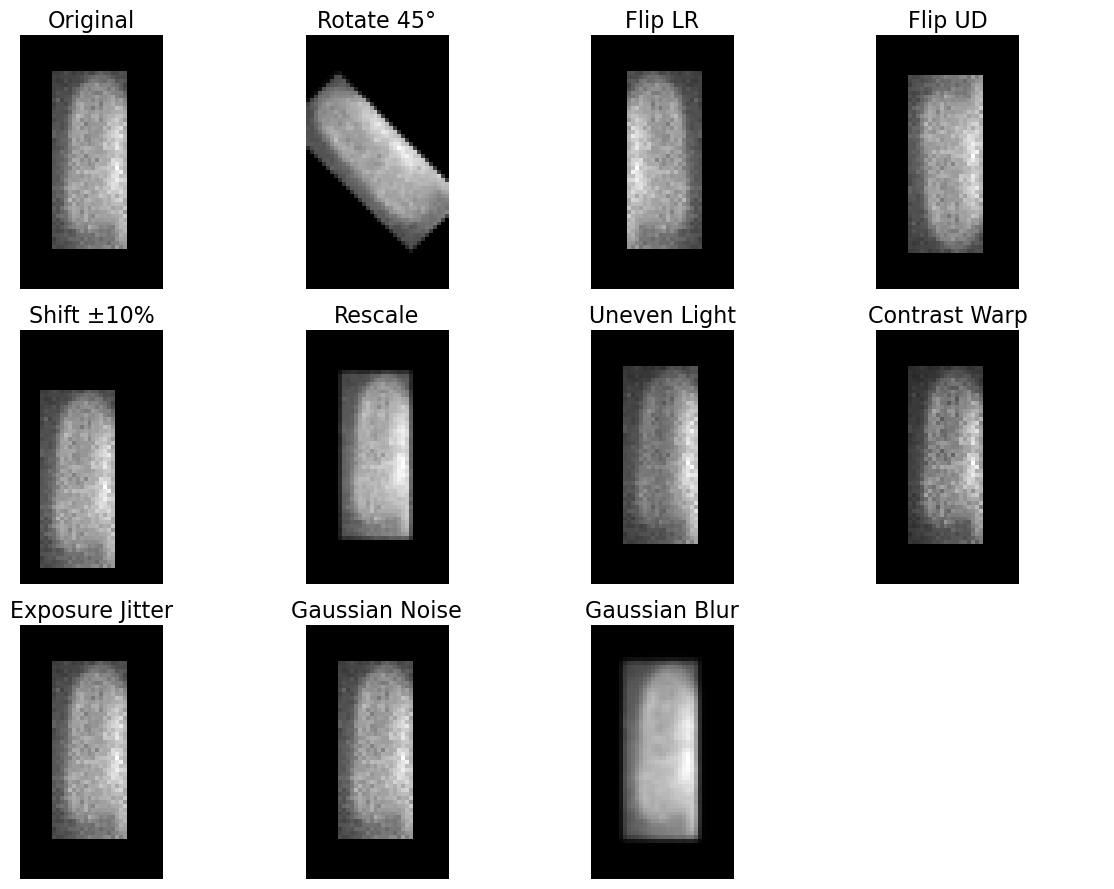

In [61]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.ndimage import rotate, shift

# --- (Re)define each augmentation as a standalone function -------

def aug_rotate(image):
    angle = 45  # fixed for illustration, you can randomize
    return tf_rotate(image, angle, order=1)

def aug_flip_lr(image):
    return tf.image.flip_left_right(image)

def aug_flip_ud(image):
    return tf.image.flip_up_down(image)

def aug_shift(image):
    return tf_shift(image, 0.1, -0.1, order=1)

def aug_rescale(image):
    return tf_random_rescale_to_fixed_size(image, 64, 36, 0.8, 1.2)

def tf_illumination_voodoo(image, num_control_points=5):
    image = tf.cast(image, tf.float32)
    control_points = tf.linspace(0.0, tf.cast(tf.shape(image)[1], tf.float32) - 1.0, num_control_points)
    random_points = tf.random.uniform([num_control_points], minval=0.7, maxval=1.3)
    interp_points = tf.linspace(0.0, tf.cast(tf.shape(image)[1], tf.float32) - 1.0, tf.shape(image)[1])
    curve = tfp.math.interp_regular_1d_grid(
        interp_points,
        control_points[0],
        control_points[-1],
        random_points,
        fill_value="constant_extension",
    )
    curve = tf.reshape(curve, [1, -1, 1])
    curve = tf.tile(curve, [tf.shape(image)[0], 1, tf.shape(image)[2]])
    return image * curve

def aug_illum(image):
    return tf_illumination_voodoo(image, num_control_points=5)

def tf_histogram_voodoo(image, num_control_points=1):
    original_points = tf.linspace(0.0, 1.0, num=num_control_points + 2)
    target_points = tf.linspace(0.0, 1.0, num=num_control_points + 2)
    random_values = tf.random.uniform([num_control_points], 0.2, 0.8)
    sorted_random = tf.sort(random_values)
    target_points = tf.tensor_scatter_nd_update(
        target_points,
        tf.reshape(tf.range(1, num_control_points + 1), [-1, 1]),
        sorted_random,
    )
    flat_image = tf.reshape(image, [-1])
    interp_values = tfp.math.interp_regular_1d_grid(
        flat_image,
        original_points[0], original_points[-1],
        target_points,
        fill_value="constant_extension",
    )
    return tf.reshape(interp_values, tf.shape(image))

def aug_hist(image):
    return tf_histogram_voodoo(image, num_control_points=1)

def aug_bright_contrast(image):
    img = tf.image.random_brightness(image, 100)
    img = tf.image.random_contrast(img, 10, 100)
    return img

def aug_noise(image):
    return tf_add_gaussian_noise(image, gaussian_noise_max=0.1)

def aug_blur(image):
    return tf_apply_gaussian_blur(image, gaussian_blur_sigma_max=1)

# --- Load one example image from your dataset --------------------

BASE     = os.getcwd()
train_pkl = r"D:\PRISM\Mother Cell For PRISM Train\merged\CNN_dataset\train.pkl"
images, labels = pickle.load(open(train_pkl, "rb"))

# pick a fixed sample, normalize and add channel dim
im = images[2608].astype(np.float32)
im_tf = tf.convert_to_tensor(im[..., None])
im_tf = (im_tf - tf.reduce_min(im_tf)) / (tf.reduce_max(im_tf) - tf.reduce_min(im_tf) + 1e-8)

# --- Apply each augmentation separately --------------------------

aug_funcs = [
    ("Original", lambda x: x),
    ("Rotate 45°", aug_rotate),
    ("Flip LR", aug_flip_lr),
    ("Flip UD", aug_flip_ud),
    ("Shift ±10%", aug_shift),
    ("Rescale", aug_rescale),
    ("Uneven Light", aug_illum),
    ("Contrast Warp", aug_hist),
    ("Exposure Jitter", aug_bright_contrast),
    ("Gaussian Noise", aug_noise),
    ("Gaussian Blur", aug_blur),
]

results = [(name, func(im_tf).numpy().squeeze()) for name, func in aug_funcs]

# --- Plot side by side -------------------------------------------

n = len(results)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for ax, (name, img) in zip(axes, results):
    ax.imshow(img, cmap='gray')
    ax.set_title(name, fontsize=16)
    ax.axis('off')

# hide any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Make augumented dataset with the same number of examples per class
import os, pickle
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.ndimage import rotate, shift
from tqdm.auto import tqdm

# ─── CONFIG ─────────────────────────────────────────────────────────────
BASE                 = os.getcwd()
# IN_PKL               = os.path.join(BASE,
#                        "Mother Cell For PRISM Train", "merged",
#                        "CNN_dataset", "train.pkl")
IN_PKL               = os.path.join(BASE,
                       "General_Test_PRISM", "merged",
                       "CNN_dataset", "train.pkl")
# OUT_PKL              = os.path.join(BASE,
#                        "Mother Cell For PRISM Train", "merged",
#                        "CNN_dataset", "augmented_train.pkl")
OUT_PKL              = os.path.join(BASE,
                       "General_Test_PRISM", "merged",
                       "CNN_dataset", "augmented_train.pkl")
num_image_per_class  = 15000
# ────────────────────────────────────────────────────────────────────────


# ─── (Defined in previous cell) AUGMENTATION FUNCS ─────────────────────────────────────────────────
# def tf_rotate(image, angle, order=1):
#     def _rot(img, ang, o):
#         arr = img.numpy()
#         return rotate(arr, ang, axes=(0,1), reshape=False, mode="nearest", order=o)
#     out = tf.py_function(_rot, [image, angle, order], tf.float32)
#     out.set_shape(image.get_shape())
#     return out

# def tf_illumination_voodoo(image, num_control_points=5):
#     image = tf.cast(image, tf.float32)
#     w = tf.shape(image)[1]
#     cp = tf.linspace(0., tf.cast(w-1, tf.float32), num_control_points)
#     rp = tf.random.uniform([num_control_points], 0.8, 1.2)
#     xp = tf.linspace(0., tf.cast(w-1, tf.float32), w)
#     curve = tfp.math.interp_regular_1d_grid(
#         xp, cp[0], cp[-1], rp, fill_value="constant_extension")
#     curve = tf.reshape(curve, [1, -1, 1])
#     curve = tf.tile(curve, [tf.shape(image)[0],1,tf.shape(image)[2]])
#     return image * curve

# def tf_histogram_voodoo(image, num_control_points=1):
#     ops = tf.linspace(0.,1.,num_control_points+2)
#     tps = tf.linspace(0.,1.,num_control_points+2)
#     rv = tf.random.uniform([num_control_points], 0.4, 0.6)
#     rv = tf.sort(rv)
#     tps = tf.tensor_scatter_nd_update(
#         tps,
#         tf.reshape(tf.range(1, num_control_points+1),[-1,1]),
#         rv)
#     flat = tf.reshape(image, [-1])
#     iv = tfp.math.interp_regular_1d_grid(
#         flat, ops[0], ops[-1], tps,
#         fill_value="constant_extension")
#     return tf.reshape(iv, tf.shape(image))

# def tf_add_gaussian_noise(image, gaussian_noise_max=0.1):
#     σ = tf.random.uniform((), 0, gaussian_noise_max)
#     n = tf.random.normal(tf.shape(image), 0., σ)
#     return tf.clip_by_value(image + n, 0., 1.)

# def tf_apply_gaussian_blur(image, gaussian_blur_sigma_max=3.0):
#     c = image.shape[-1]
#     σ = tf.random.uniform((), 0, gaussian_blur_sigma_max)
#     size = tf.cast(tf.math.ceil(σ*3), tf.int32)
#     d = tfp.distributions.Normal(0., σ)
#     vals = d.prob(tf.range(-size, size+1, dtype=tf.float32))
#     kernel = tf.einsum('i,j->ij', vals, vals)
#     kernel = kernel / tf.reduce_sum(kernel)
#     kernel = kernel[:,:,None,None]
#     kernel = tf.tile(kernel, [1,1,c,1])
#     img4 = tf.expand_dims(image,0)
#     blurred = tf.nn.depthwise_conv2d(img4, kernel, [1,1,1,1], 'SAME')
#     return tf.squeeze(blurred,0)

# def tf_shift(image, sy, sx, order=1):
#     def _sh(img, y, x, o):
#         arr = img.numpy()
#         dy = int(arr.shape[0]*y)
#         dx = int(arr.shape[1]*x)
#         return shift(arr, [dy,dx,0], order=o, mode='nearest')
#     out = tf.py_function(_sh, [image, sy, sx, order], tf.float32)
#     out.set_shape(image.get_shape())
#     return out

# def augment(image, label):
#     # image ∈ [0,1], shape [H,W,1]
#     if tf.random.uniform(()) < 0.5:
#         ang = tf.random.uniform((), -180, 180)
#         image = tf_rotate(image, ang, 1)
#     if tf.random.uniform(()) < 0.5:
#         image = tf.image.random_flip_left_right(image)
#     if tf.random.uniform(()) < 0.5:
#         image = tf.image.random_flip_up_down(image)
#     if tf.random.uniform(()) < 0.5:
#         dy = tf.random.uniform((), -0.1, 0.1)
#         dx = tf.random.uniform((), -0.1, 0.1)
#         image = tf_shift(image, dy, dx, 1)
#     if tf.random.uniform(()) < 0.2:
#         image = tf_illumination_voodoo(image)
#     if tf.random.uniform(()) < 0.2:
#         image = tf_histogram_voodoo(image)
#     if tf.random.uniform(()) < 0.5:
#         image = tf.image.random_brightness(image, 0.1)
#         image = tf.image.random_contrast(image, 0.85, 1.15)
#     if tf.random.uniform(()) < 0.5:
#         image = tf_add_gaussian_noise(image, 0.05)
#     if tf.random.uniform(()) < 0.3:
#         image = tf_apply_gaussian_blur(image, 1.0)
#     image = tf.clip_by_value(image, 0., 1.)
#     return image, label
# ────────────────────────────────────────────────────────────────────────


# ─── LOAD ORIGINAL TRAINING SET ─────────────────────────────────────────
with open(IN_PKL, "rb") as fh:
    base_images, base_labels = pickle.load(fh)

# group by label
labels_arr   = np.array(base_labels, dtype=int)
unique_lbls  = np.unique(labels_arr)
by_label_idxs = {lbl: np.where(labels_arr == lbl)[0].tolist()
                 for lbl in unique_lbls}

# quick normalize helper
def normalize_np(im):
    im = im.astype(np.float32)
    mn, mx = im.min(), im.max()
    return (im - mn) / (mx - mn + 1e-8)

rng = np.random.RandomState(123)

aug_images = []
aug_labels = []

for lbl in unique_lbls:
    idxs = by_label_idxs[lbl]
    n_have = len(idxs)
    print(f"> Class {lbl}: have {n_have}, target {num_image_per_class}")
    pbar = tqdm(total=num_image_per_class, desc=f"Class {lbl}", leave=False)

    count = 0
    while count < num_image_per_class:
        i = rng.choice(idxs)
        im = base_images[i]
        t = tf.convert_to_tensor(im.astype(np.float32))
        if t.ndim == 2:
            t = tf.expand_dims(t, -1)
        t = (t - tf.reduce_min(t)) / (tf.reduce_max(t) - tf.reduce_min(t) + 1e-8)
        aug_t, _ = augment(t, lbl)
        aug_np = aug_t.numpy().squeeze()
        aug_np = normalize_np(aug_np)
        aug_images.append(aug_np)
        aug_labels.append(lbl)
        count += 1
        pbar.update(1)

    pbar.close()


# shuffle all
combined = list(zip(aug_images, aug_labels))
rng.shuffle(combined)
aug_images, aug_labels = zip(*combined)

# save
with open(OUT_PKL, "wb") as fh:
    pickle.dump((list(aug_images), list(aug_labels)), fh)

print(f"\n✅ Augmented training set saved to {OUT_PKL}")
print(f"   total examples: {len(aug_images)} (= {num_image_per_class} × {len(unique_lbls)})")


> Class 0: have 1583, target 15000


Class 0:   0%|          | 0/15000 [00:00<?, ?it/s]

> Class 1: have 111, target 15000


Class 1:   0%|          | 0/15000 [00:00<?, ?it/s]

> Class 2: have 2114, target 15000


Class 2:   0%|          | 0/15000 [00:00<?, ?it/s]

> Class 3: have 1728, target 15000


Class 3:   0%|          | 0/15000 [00:00<?, ?it/s]


✅ Augmented training set saved to d:\PRISM\General_Test_PRISM\merged\CNN_dataset\augmented_train.pkl
   total examples: 60000 (= 15000 × 4)
